# Progettino AQM

# Alla ricerca dell'autovalore dello stato fondamentale dell'hamiltoniana

#### Autori:
Dott. Michele Grossi<br>
Francesco De Luca<br>
Ian Gremese<br>
Carlo Zollo

##### COSE CHE MANCANO
-Grafici spettri: Fatto mancano considerazioni spettri <br>
-Grafici ottimizzatori: Carlo <br>
-Grafici Ansatz <br>
-Grafici Circuito: Fatto Tutto e di più (da rieseguire con più qubit (meno di 10)) <br>

### Variational Quantum Eigensolver

##### Generalità

VQE: ricerca del minimo autovalore di un operatore hermitiano $\hat H$
- algoritmo ibrido classico-quantistico
- un approccio variazionale

Parametrizzazione $\left|\psi(\theta)\right> \quad \rightarrow \quad$ stima $E_{\theta}$ di $E_\text{min}: \quad E_\text{min} \leq E_{\theta} = \left<\psi(\theta)\middle|\hat H\middle|\psi(\theta)\right>\ .$

##### Componenti fondamentali

- _ansatz_: circuito quantistico (`QuantumCircuit()`) parametrizzato con $\theta$ che prepara lo stato di prova implementando l'evolutore unitario $\hat U(\theta)$;
- _ottimizzatore_: routine di minimizzazione classica (`optimizers`) che stabilisce i valori di $\theta$.

##### Procedimento

Il procedimento consiste nella ripetizione dei seguenti passaggi:

Parte quantistica:
1. $\left|\psi_0\right> \rightarrow\left|\psi(\theta)\right> = \hat U(\theta)\left|\psi_0\right>$

2. misura di $\left<\psi(\theta)\middle|\hat H\middle|\psi(\theta)\right>$

Parte classica:

1. ottimizzatore fornisce un nuovo set $\theta'$ di parametri per la successiva iterazione.

Iterando questo processo si giunge a uno stato arbitrariamente (almeno idealmente) vicino a $\left|\psi_\text{min}\right>$.

##### Aspetti da tenere a mente

Per una buona stima di $E_\text{min}$ sono fondamentalmente due gli aspetti di cui tener conto;

- ansatz:
    1. deve essere che $\exists \theta: \hat U(\theta)\left|\psi_0\right> = \left|\psi_\text{min}\right>$;
    2. usare meno parametri $\theta$ possibile per limitare la complessità dell'analisi e gli errori di calcolo;
- hardware:
    1. rumore $\rightarrow$ la funzione che calcola $\langle \hat H \rangle$ non riflette necessariamente la realtà;
    2. per alcuni ottimizzatori $\langle \hat H \rangle$ il numero di valutazioni di $\theta$ dipende dal loro numero.

È quindi importante la scelta di ansatz e ottimizzatore efficienti ed efficaci, dipendente dalla situazione fisica in esame.

### Armamentario generale, da caricare prima delle diverse operazioni

#### Diagonalizzazione computazionale "classica"

Codice funzionale alla compilazione delle hamiltoniane da diagonalizzare.

Importiamo operatori e matrici di Pauli

In [15]:
from qiskit.quantum_info.operators import Operator, Pauli

Funzione per la diagonalizzazione classica di una lista di lunghezza variabile di operatori $\hat H$, che ha la forma `([H0, H1, H2, ...], )`.

In [17]:
import numpy as np
from numpy import linalg
from math import sqrt

def class_par_H_diagonalizer(*H):
    E_l = []
    P_l = []
    Eivals = []
    GSvals = []
    num_qubits = 2

    for k in H[0]: #H is ([H0, H1, ...],), so Hj can be selected as H[0][j]
        E_l, P_l = linalg.eig(k.data)
        E_l = np.real(E_l)
        Eivals.append(np.sort(E_l))
        GSvals.append(np.min(E_l))
        
    return GSvals, Eivals

#### Diagonalizzazione quantistica con il VQE

Codice per la scrittura delle hamiltoniane da diagonalizzare:

In [18]:
import numpy as np
from numpy import linalg
from qiskit.opflow import X, Y, Z, I, primitive_ops

Funzione che cerca il minimo autovalore dell'hamiltoniana:

In [19]:
from IPython.display import display as ipd_display, clear_output as ipd_clear, Markdown
from qiskit.algorithms import VQE
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex

def VQE_par_H_diagonalizer(local_vqe,*H):
    
    #Ci riferiamo alla variabile globale
    #perché cambia il modo in cui la "passa".
    #Se non facciamo così dopo non riesce a modificarla
    global intermediate_info
    intermediate_info = {
        'nfev': [],
        'parameters': [],
        'energy': [],
        'stddev': []
    }
    
    GSvals = []
    GSstat = []
    meanerr = []
    
    for i in range(len(H[0])):
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(i+1,len(H[0])))
    
        local_result = local_vqe.compute_minimum_eigenvalue(H[0][i])
        GSvals.append(np.real(local_result.eigenvalue))
        GSstat.append(local_result.eigenstate)
        meanerr.append(intermediate_info['stddev'][-1])
    
    ipd_clear(wait=True)
    ipd_display("Finito.")
    
    return GSvals, GSstat, meanerr

Funzione per la raccolta di dati relativi all'ottimizzazione del VQE:

In [20]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    global intermediate_info
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

#### Funzioni per i grafici

Funzione usata per i grafici degli spettri calcolati con algoritmi computazionali classici e le energie di stato fondamentale determinate analiticamente:

In [21]:
import matplotlib.pyplot as plt

def plot_class(lists):

    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
#    pylab.rcParams.update({'font.size': 15})
    plt.xticks(B)

    #itero sulle diverse tecniche che ho utilizzato
    for i in range(2,len(lists)):
        ax.plot(B, lists[i], color="#FF9900", linewidth=1.5)
        
    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.7)

    ax.set(xlabel='Campo magnetico B', ylabel='Energia', title='VQE su simulatore locale per 2 atomi')

    ax.grid()
    plt.show()

Funzione usata per il confronto degli spettri calcolati classicamente con quelli trovati mediante VQE:

In [22]:
import matplotlib.pyplot as plt

#Funzione utilizzate per il plot delle energie: Accetta un input del tipo:
# [EnergiaClassicaDelGroundState,AutovaloriDelleEnergie,EnergiaRicavataAttraversoAltreTecniche]

def plot_tot(lists):

    #plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    plt.xticks(B)
    #pylab.rcParams.update({'font.size': 15})
    #ax.scatter(b, energy, marker='o')
    ax.scatter(B, lists[0], marker='o')
    ax.plot(B, lists[1], color="#000000", linewidth=0.5)
    
    #itero sulle diverse tecniche che ho utilizzato
    for i in range(2,len(lists)):
        ax.scatter(B, lists[i], marker='x')

    ax.set(xlabel='Campo magnetico B', ylabel='Energia', title='VQE su simulatore locale per 2 atomi')

    ax.grid()
    plt.show()

Funzioni varie per la visualizzazione degli spettri energetici:

In [106]:
def plot_spectrum(list,B,Natoms):
    
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    ax.plot(B, list, color="#000000", linewidth=1.)
    ax.set(xlabel='Campo Magnetico B', ylabel='Energia', title='Spettro di energia per {} atomi'.format(Natoms))
    ax.grid()
#    pylab.rcParams.update({'font.size': 15})
    plt.show()
    
def plot_spectrum_closeup(list,B,low,high,Natoms):
    
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    ax.plot(B, list, color="#000000", linewidth=1.)
    ax.set(xlabel='Campo Magnetico B', ylabel='Energia', title='Spettro di energia per {} atomi'.format(Natoms))
    ax.set_ylim([low, high])
#    pylab.rcParams.update({'font.size': 15})
    plt.show()

def spectrum_class(Bmin,Bmax,Nstep,Natoms,J,gy,gz):
    
    B=[]
    B = np.linspace(Bmin,Bmax,Nstep).tolist()
    cH = []
    for k in B:
        cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    cGSEigE, EigE = class_par_H_diagonalizer(cH)
    
    plot_spectrum(EigE,B,Natoms)
    
#def spectrum_class(Bmin,Bmax,Nstep,Natoms,J,gy,gz):
#    
#    B=[]
#    B = np.linspace(Bmin,Bmax,Nstep).tolist()
#    cH = []
#    for k in B:
#        cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
#    return cGSEigE, EigE = class_par_H_diagonalizer(cH)
    
def spectrum_class_closeup(Bmin,Bmax,Nstep,Natoms,J,gy,gz,low,high):
    
    
    B=[]
    B = np.linspace(Bmin,Bmax,Nstep).tolist()
    cH = []
    for k in B:
        cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    cGSEigE, EigE = class_par_H_diagonalizer(cH)

    plot_spectrum_closeup(EigE,B,low,high,Natoms)

Funzione per il grafico sovrapposto della linea dello stato fondamentale (calcolata classicamente) e delle energie ricavate attraverso VQE.

In [101]:
def pre_plot_qGS(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr):
    
    B=[]
    Beval=[]
    B = np.linspace(Bmin,Bmax,Nstep).tolist()
    Beval= np.linspace(Bmin,Bmax,Neval).tolist()
    
    #Valutazione del ground state per lo spettro
    
    cH = []
    for k in B:
            cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    cGSEigE, EigE = class_par_H_diagonalizer(cH)
    
    #Valutazione del ground state per il confronto con VQE (può essere ottimizzato)
    
    cHeval=[]
    for j in Beval:
        cHeval.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,j))
    cGSEigEval, EigEval = class_par_H_diagonalizer(cHeval)
    return cGSEigEval, EigEval
    
def plot_qGS(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr):
#    pylab.rcParams.update({'font.size': 15})
    cGSEigEval, EigEval = pre_plot_qGS(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr)
    
    #Grafico
    Beval= np.linspace(Bmin,Bmax,Neval).tolist()
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    plt.xticks(Beval)
    ax.plot(B, cGSEigE, color="#000000", linewidth=0.5)
    ax.scatter(Beval,cGSEigEval, marker='x')
    plt.errorbar(Beval, qGS,yerr=qGSerr, fmt='o')
    ax.set(xlabel='Campo Magnetico B', ylabel='Energia', title='VQE su simulatore locale per {} atomi'.format(Natoms))

    ax.grid()
    
    plt.show()
    
def plot_qGS_spectrum(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr):
    
    cGSEigEval, EigEval = pre_plot_qGS(Bmin,Bmax,Nstep,Neval,Natoms,J,gy,gz,qGS,qGSerr)
    
    B=[]
    B = np.linspace(Bmin,Bmax,Nstep).tolist()
    cH = []
    for k in B:
        cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))
    cGSEigE, EigE = class_par_H_diagonalizer(cH)
    
    Beval= np.linspace(Bmin,Bmax,Neval).tolist()
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    plt.xticks(Beval)
    ax.plot(B, EigE, color="#000000", linewidth=0.5)
    ax.scatter(Beval,cGSEigEval, marker='x')
    plt.errorbar(Beval, qGS,yerr=qGSerr, fmt='o')
    ax.set(xlabel='Campo Magnetico B', ylabel='Energia', title='VQE su simulatore locale e spettro di energia per {} atomi'.format(Natoms))
    ax.grid()

    plt.show()

Funzione per il grafico sovrapposto della linea dello stato fondamentale (calcolata classicamente) e delle energie ricavate attraverso VQE.

Funzioni per i grafici degli errori:

In [89]:
#Funzioni per il plot degli errori

def plot_relerr(B,cGS,qGS):
    relerr=[]
    for i in range(len(B)):
        relerr.append(abs((cGS[i]-qGS[i])/cGS[i]))
        
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    ax.rcParams.update({'font.size': 15})
    plt.xticks(B)
    ax.scatter(B,relerr, marker='x')
    
    ax.set(xlabel='Campo Magnetico B', ylabel='Errore relativo', title='')
    ax.grid()
    pylab.rcParams.update({'font.size': 15})
    plt.show()

def plot_abserr(B,cGS,qGS):
    abserr=[]
    for i in range(len(B)):
        abserr.append(abs(cGS[i]-qGS[i]))
        
    fig, ax = plt.subplots(figsize=(6,4), dpi=700)
    
    plt.xticks(B)
    ax.scatter(B,abserr, marker='x')
    
    ax.set(xlabel='Campo Magnetico B', ylabel='Errore assoluto', title='Errori assoluti sulle stime del VQE')
    ax.grid()
#    pylab.rcParams.update({'font.size': 15})
    plt.show()


#### Hardware/Simulator VQE

Comandi per il caricamento i moduli che occorrono per l'esecuzione su hardware reale:

In [133]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise
from qiskit_nature.runtime import VQEProgram #VQEClient
from qiskit.test.mock import FakeVigo
from qiskit.providers.basicaer import QasmSimulatorPy, StatevectorSimulatorPy
from qiskit.algorithms import VQE

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy #si può cercare l'equivalente Aer
from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.visualization import plot_state_qsphere, plot_bloch_multivector
import qiskit.quantum_info as qi

##### Accesso a IBM Quantum

In [27]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

##### Assegnazione dell'hardware e configurazione dell'esecuzione

Funzione che costruisce prima la quantum instance, poi l'istanza della VQE a partire dai parametri immessi dall'utente relativamente a:
- strumentazione: hardware, simulatore con/senza rumore;
- numero di <i>shots</i>;
- ottimizzatore: COBYLA, SPSA e GradientDescent :

In [28]:
def Custom_VQE_diag(BK,shots,optimizer):
    
    #Parte 1: definisco la quantum_instance
    
    #HW = 'ibmq_belem'
    BK = "noiseless" # "IBMnoisy", "Aernoisy", "noiseless", "hardware"

    if BK == "noiseless":

        backend = Aer.get_backend("aer_simulator")
        quantum_instance = QuantumInstance(backend,
                                           shots=shots)

        print(quantum_instance)

    if BK == "IBMnoisy":

        #device = IBMQ.get_provider().get_backend(HW)
        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= Natoms and x.configuration().simulator))
        prop = backend.properties()
        #print(dir(backend.configuration()))
        #print(dir(backend.options))

        coupling_map = backend.configuration().coupling_map
        noise_model = backend.options.noise_model
        basis_gates = backend.configuration().basis_gates

        #backend = Aer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend,
                                           shots=shots,
                                           noise_model=noise_model,
                                           basis_gates=basis_gates,
                                           coupling_map=coupling_map)

        print(quantum_instance)

    if BK == "Aernoisy":

        #Aer.backends()
        backend = Aer.get_backend('aer_simulator')
        #prop = backend.properties()
        #print(dir(backend))

        #Prendo i modelli per la simulazione con rumore da FakeVigo
        device = QasmSimulator.from_backend(FakeVigo())
        
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates

        #seed = 170
        #iterations = 125
        #algorithm_globals.random_seed = seed

        quantum_instance = QuantumInstance(backend,
                                           noise_model=noise_model,
                                           basis_gates=basis_gates,
                                           seed_simulator=seed,
                                           seed_transpiler=seed,
                                           coupling_map=coupling_map)

        print(quantum_instance)

    if BK == "hardware":

        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= Natoms and not x.configuration().simulator))
        print(backend)
        
    #Parte 2: definisco l'istanza della VQE
        
    if BK in ("IBMnoisy"):
        
        #VQEProgram invece di VQE(usata in sim locale)
        vqe = VQEProgram(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 provider=provider, ##
                 backend=backend, ##
                 shots=shots, ##
                 measurement_error_mitigation=measurement_error_mitigation, ##
                 quantum_instance=quantum_instance, ####
                 callback=callback)

    if BK in ("hardware"):
        
        vqe = VQEProgram(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 provider=provider, ##
                 backend=backend, ##
                 shots=shots, ##
                 measurement_error_mitigation=measurement_error_mitigation, ##
                 callback=callback)

    if BK in ("Aernoisy","noiseless"):
        
        vqe = VQE(ansatz=ansatz,
                 optimizer=optimizer,
                 initial_point=initial_point,
                 quantum_instance=quantum_instance,
                 callback=callback)    
        
    qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(vqe,qH)
    
    return qGSEigE, meanerr

## Hamiltoniana n. 1: Modello di Lipkin-Meshkov-Glick

$$\hat H = - \sum_{\substack{i,j=1\\i<j}}^N J\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma\hat \sigma_y^{(i)}\hat \sigma_y^{(j)}\right) - B \sum_{i=1}^n \hat\sigma_z^{(i)},\quad\text{con }J=\frac{1}{N}$$

### Caso con 2 atomi

### Soluzione analitica

La hamiltoniana può essere divisa in due parti:
- $\hat H_1 = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma\hat \sigma_y^{(i)}\hat \sigma_y^{(j)}\right)$, che mescola le coppie $\left|00\right>$, $\left|11\right>$ e $\left|01\right>$, $\left|10\right>$ della base computazionale;
- $\hat H_2 = - B \sum_{i=1}^n \hat\sigma_z^{(i)}$, di cui tutti gli stati della base computazionale sono autostati.

Allora basta studiare come si mescolano le due coppie individuate da $\hat H_1$ e si trovano gli autovalori di $\hat H$:
- $E=\pm\sqrt{J^2(1-\gamma)^2+4B^2}$ per la coppia $\left|00\right>$ e $\left|11\right>$;
- $E=\pm J(1+\gamma)$ per la coppia $\left|01\right>$ e $\left|10\right>$.

A questo punto, per i diversi valori di $J$ e $B$ basta vedere quale dei valori di $E$ è il minimo, ma non l'abbiamo fatto a mano perché dipende anche dal segno dei due parametri. In questo caso, comunque, siamo interessati al caso di $J=\frac{1}{N}=\frac{1}{2}$.

In [60]:
GS1 = [min(-sqrt( J**2 * (1-gy)**2 + 4*i**2 ),+J*(1+gy),-J*(1+gy)) for i in B]

Impostiamo i parametri per la nostra lista di hamiltoniane $\hat H$, cioè $J=\frac{1}{N}$, $\gamma$, e l'intervallo di $B$

In [111]:
Natoms = 2
J = 1./Natoms
gy = 2
gz = 0 #variabile coccige
Bmin=0.
Bmax=1.5
Neval=5
B = np.linspace(Bmin,Bmax,Neval).tolist()

### Diagonalizzazione computazionale classica

#### Costruzione di $\hat H$ per la diagonalizzazione classica

Costruiamo la lista delle hamiltoniane per la diagonalizzazione computazionale classica sui diversi valori di $B$, usando operatori del tipo `Operators`, anche se sembra che in `class_par_H_diagonalizer` `k.data` manipoli la matrice, sia che sia fatta con Opflow sia che sia fatta con la libreria <b>Pauli_operators</b> e quindi funziona comunque:

In [46]:
import numpy as np
from qiskit.opflow import X, Y, Z, I

def Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,B):
    
    #initialize 0-dimensional Operators
    field=Operator([0])
    spin=Operator([0])
    
    #cycle over all qubits
    for i in range(Natoms):
       
        #Adds the spin field interaction for each atom
        field = (field^I)
        field -= (B*((I^i)^Z))
        
        #Adds a qubit to the spin part
        spin = spin^I
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spin -= ( J * ((I^j)^X^(I^(i-j-1))^X))
            spin -= (J*gy*((I^j)^Y^(I^(i-j-1))^Y))
            
    return(spin+field)

#### Algoritmo per risoluzione classica

Invochiamo la funzione `spectrum_class(Bmin,Bmax,Nstep,Natoms,J,gy,gz)` che esegue la diagonalizzazione classica computazionale su un intervallo per $B$ scelto e con un campionamento arbitrariamente fine:

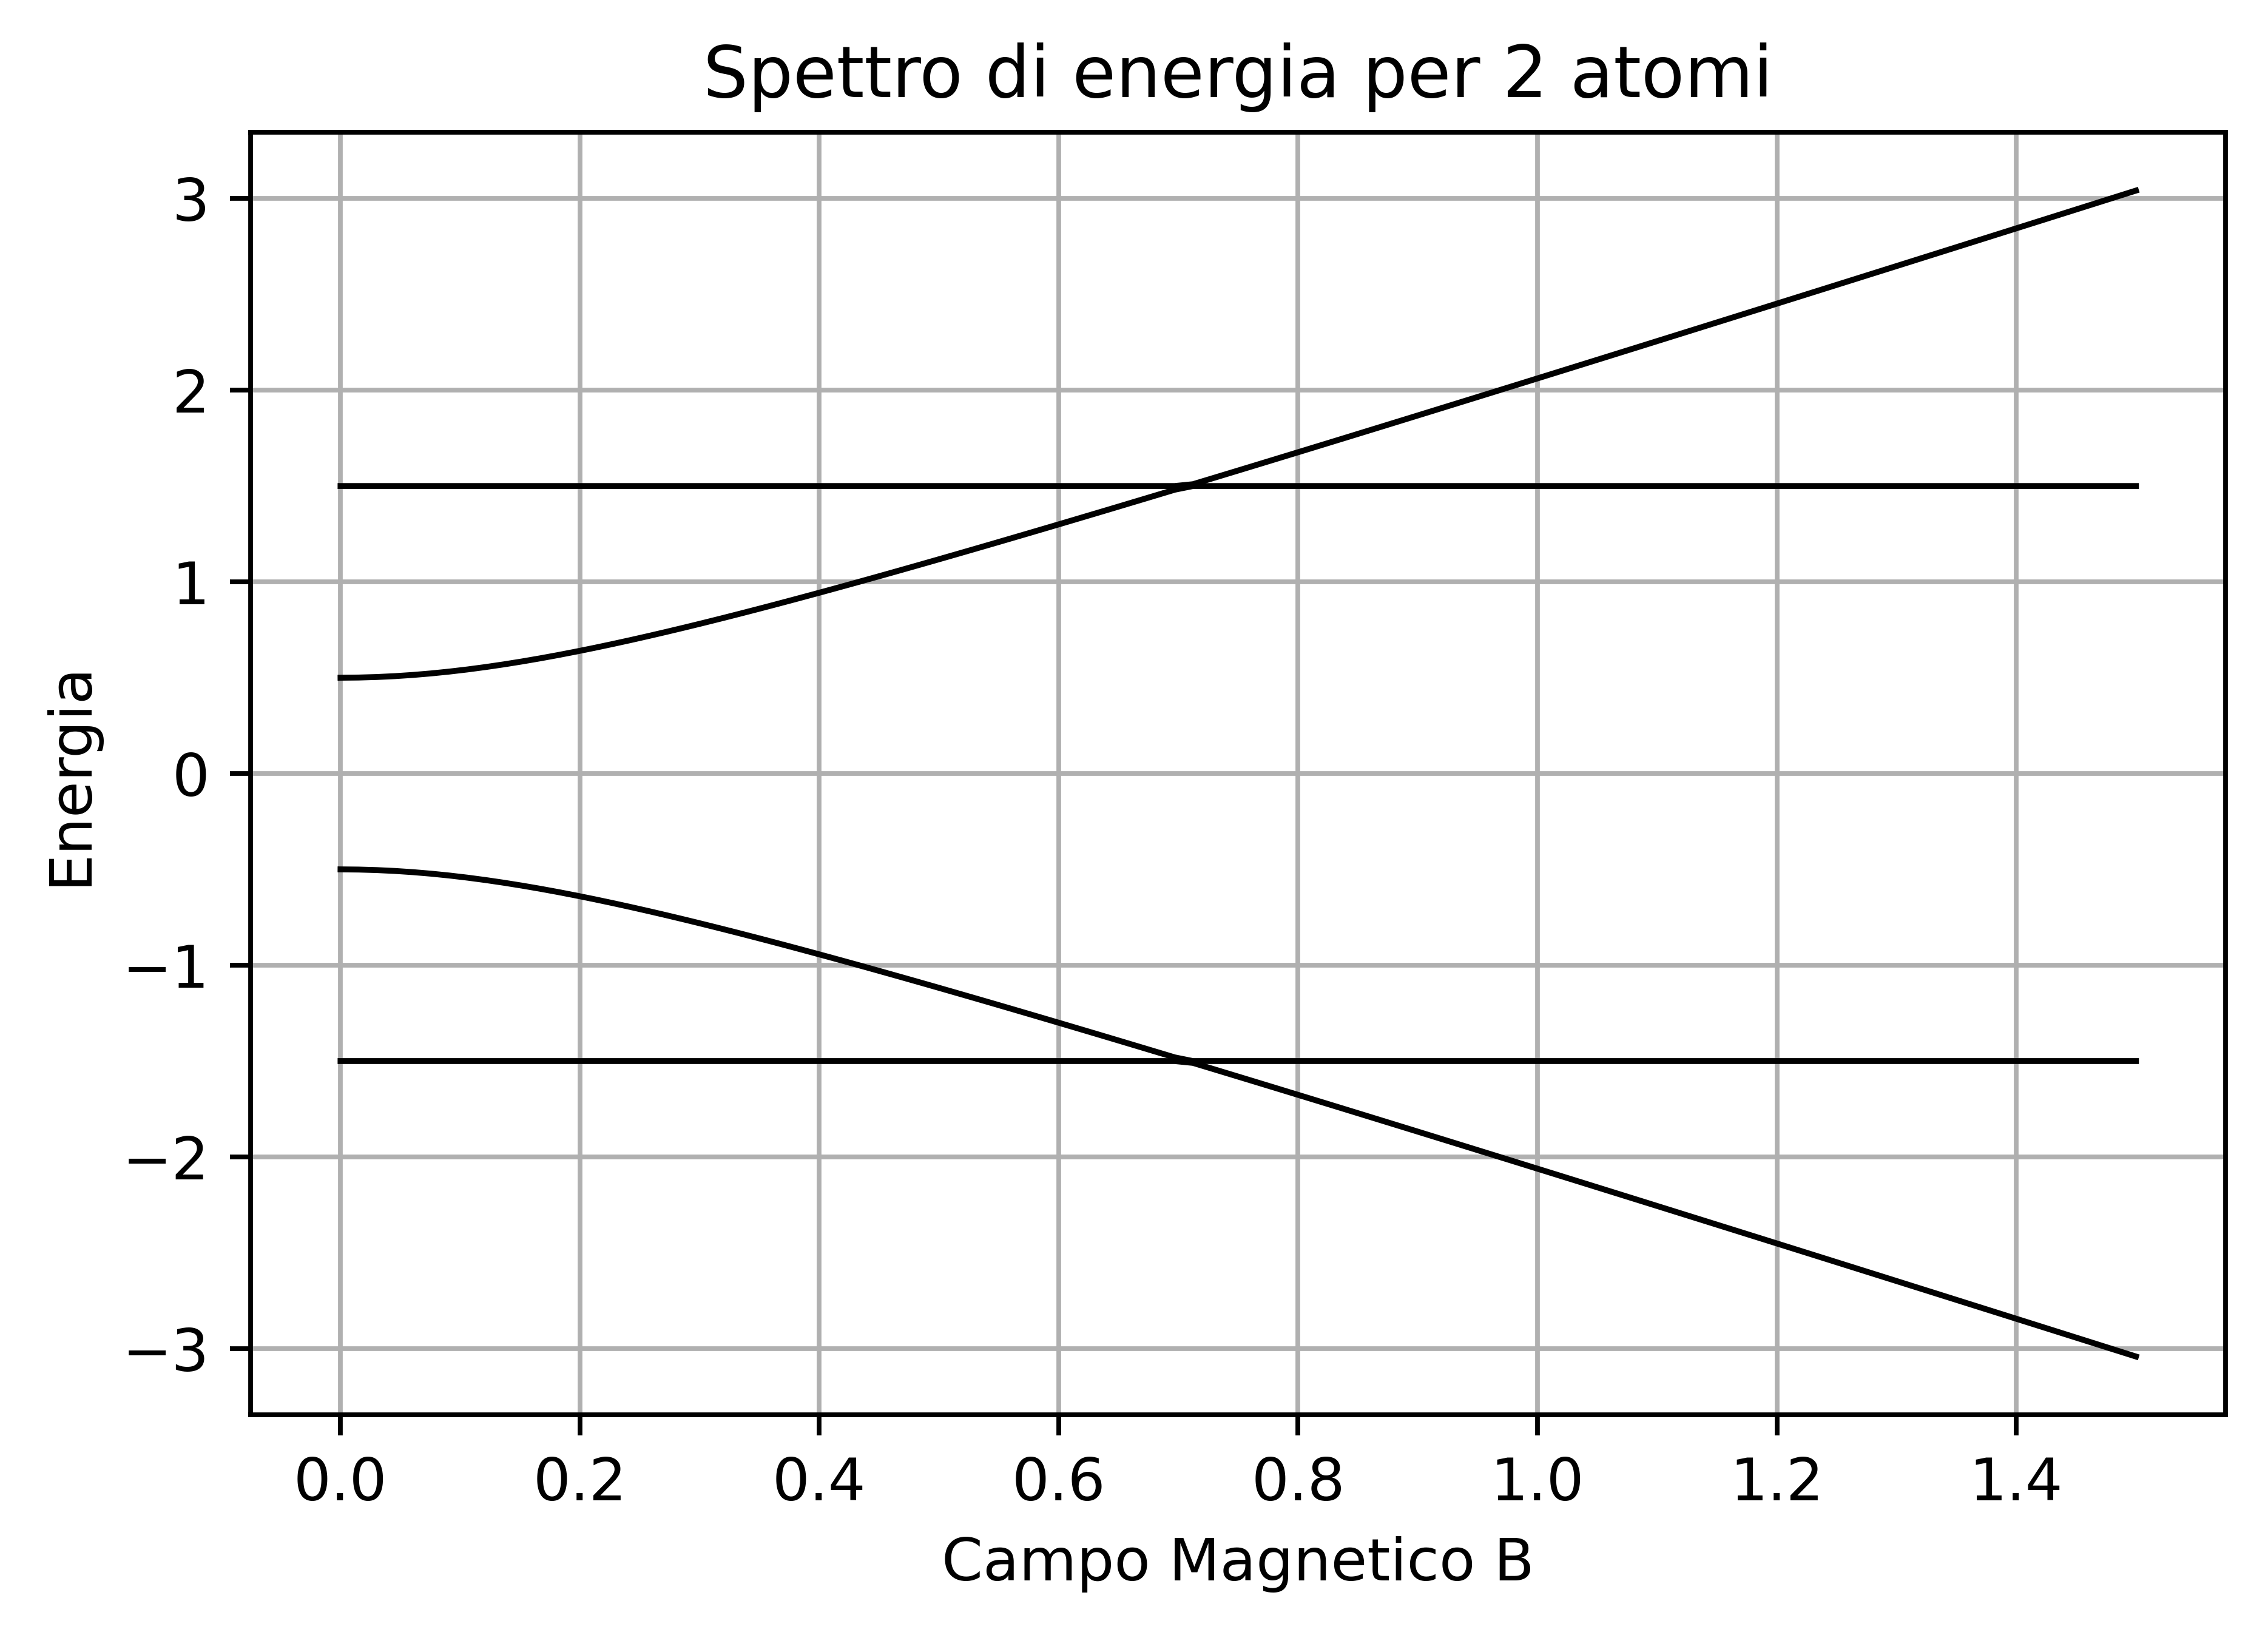

In [47]:
spectrum_class(0.,1.5,100,Natoms,J,gy,gz)

### Diagonalizzazione quantistica con il VQE locale

#### Costruzione di $\hat H$ per la diagonalizzazione quantistica
Costruiamo la lista delle hamiltoniane sui diversi valori di $B$, usando operatori del tipo `primitive_ops.PauliOp` che è l'unico tipo che l'algoritmo VQE accetta:

In [50]:
def Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction
    
    #initialize 0-dimensional Operators
    init = primitive_ops.PauliOp(Pauli('I'*Natoms),0)
    field,spins = [init]*2
    
    #cycle over all qubits
    for i in range(Natoms):
    
        #Adds the spin field interaction for each atom
        field -= primitive_ops.PauliOp(Pauli('I'*i+'Z'+'I'*(Natoms-i-1)),B)
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'X'+'I'*(i-j-1)+'X'+'I'*(Natoms-i-1)),J)
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'Y'+'I'*(i-j-1)+'Y'+'I'*(Natoms-i-1)),J*gy)

    return (field+spins)

qH = []
for k in range(len(B)):
    qH.append(Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k]))

#### Definizione dell'ansatz

##### Considerazioni specifiche:
- `EfficientSU2`:

    1. approccio euristico
    2. produce un ansatz generico efficiente in termini di hardware
    
    
- ansatz _physically-motivated_: es. noti

    - $\hat A: \left[\hat H,\hat A\right] = 0$
    - autovalore di $\hat A$ per $\left|\psi_\text{min}\right>$
    
  allora $\hat U(\theta) = \exp\left(i\theta\hat A\right)$ costringe il VQE a campionare l'autospazio di $\hat A$ per l'autovalore corrispondente a $\psi_\text{min}$. Nel nostro caso, per esempio, si trova che $\left[\hat H,\hat S_z^2\right] = 0$.

Prendiamo l'ansatz `EfficientSU2` ecc., impostandone i parametri secondo la definizione che abbiamo dato al nostro problema.

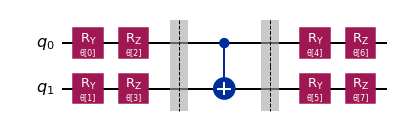

In [51]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

#### Scelta dell'ottimizzatore

##### Considerazioni specifiche:
- `EfficientSU2`:

    1. approccio euristico
    2. produce un ansatz generico efficiente in termini di hardware
    
    
- ansatz _physically-motivated_: es. noti

    - $\hat A: \left[\hat H,\hat A\right] = 0$
    - autovalore di $\hat A$ per $\left|\psi_\text{min}\right>$
    
  allora $\hat U(\theta) = \exp\left(i\theta\hat A\right)$ costringe il VQE a campionare l'autospazio di $\hat A$ per $\left<\hat A\right>_{\phi_\text{min}}$. Nel nostro caso, per esempio, si trova che $\left[\hat H,\hat S_z^2\right] = 0$.

Usiamo l'ottimizzatore SPSA:

In [52]:
optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

#### Simulazione locale della VQE

Costruiamo la funzione per il VQE con ansatz, ottimizzatore, stato iniziale, "quantum instance" e funzione di callback scelti e facciamo eseguire il VQE con i parametri scelti:

In [54]:
from qiskit.providers.basicaer import StatevectorSimulatorPy, QasmSimulatorPy

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),
                callback=callback)

qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

### Risultati

Visualizzo stime delle energie dei GS e stime degli errori:

In [55]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-1.480133153065669 0.0
-1.4880924997008669 0.0
-1.3409329969991974 0.0
-1.1339090794683906 0.0
-1.436351414954432 0.0
-1.7205582817804206 0.0
-2.046033247775665 0.0
-2.3386669991742104 0.0
-2.683112827317417 0.0
-3.0320398225579366 0.0


Visualizzo il grafico con i risultati classici e della VQE:

In [56]:
qGSEigE

[-1.480133153065669,
 -1.4880924997008669,
 -1.3409329969991974,
 -1.1339090794683906,
 -1.436351414954432,
 -1.7205582817804206,
 -2.046033247775665,
 -2.3386669991742104,
 -2.683112827317417,
 -3.0320398225579366]

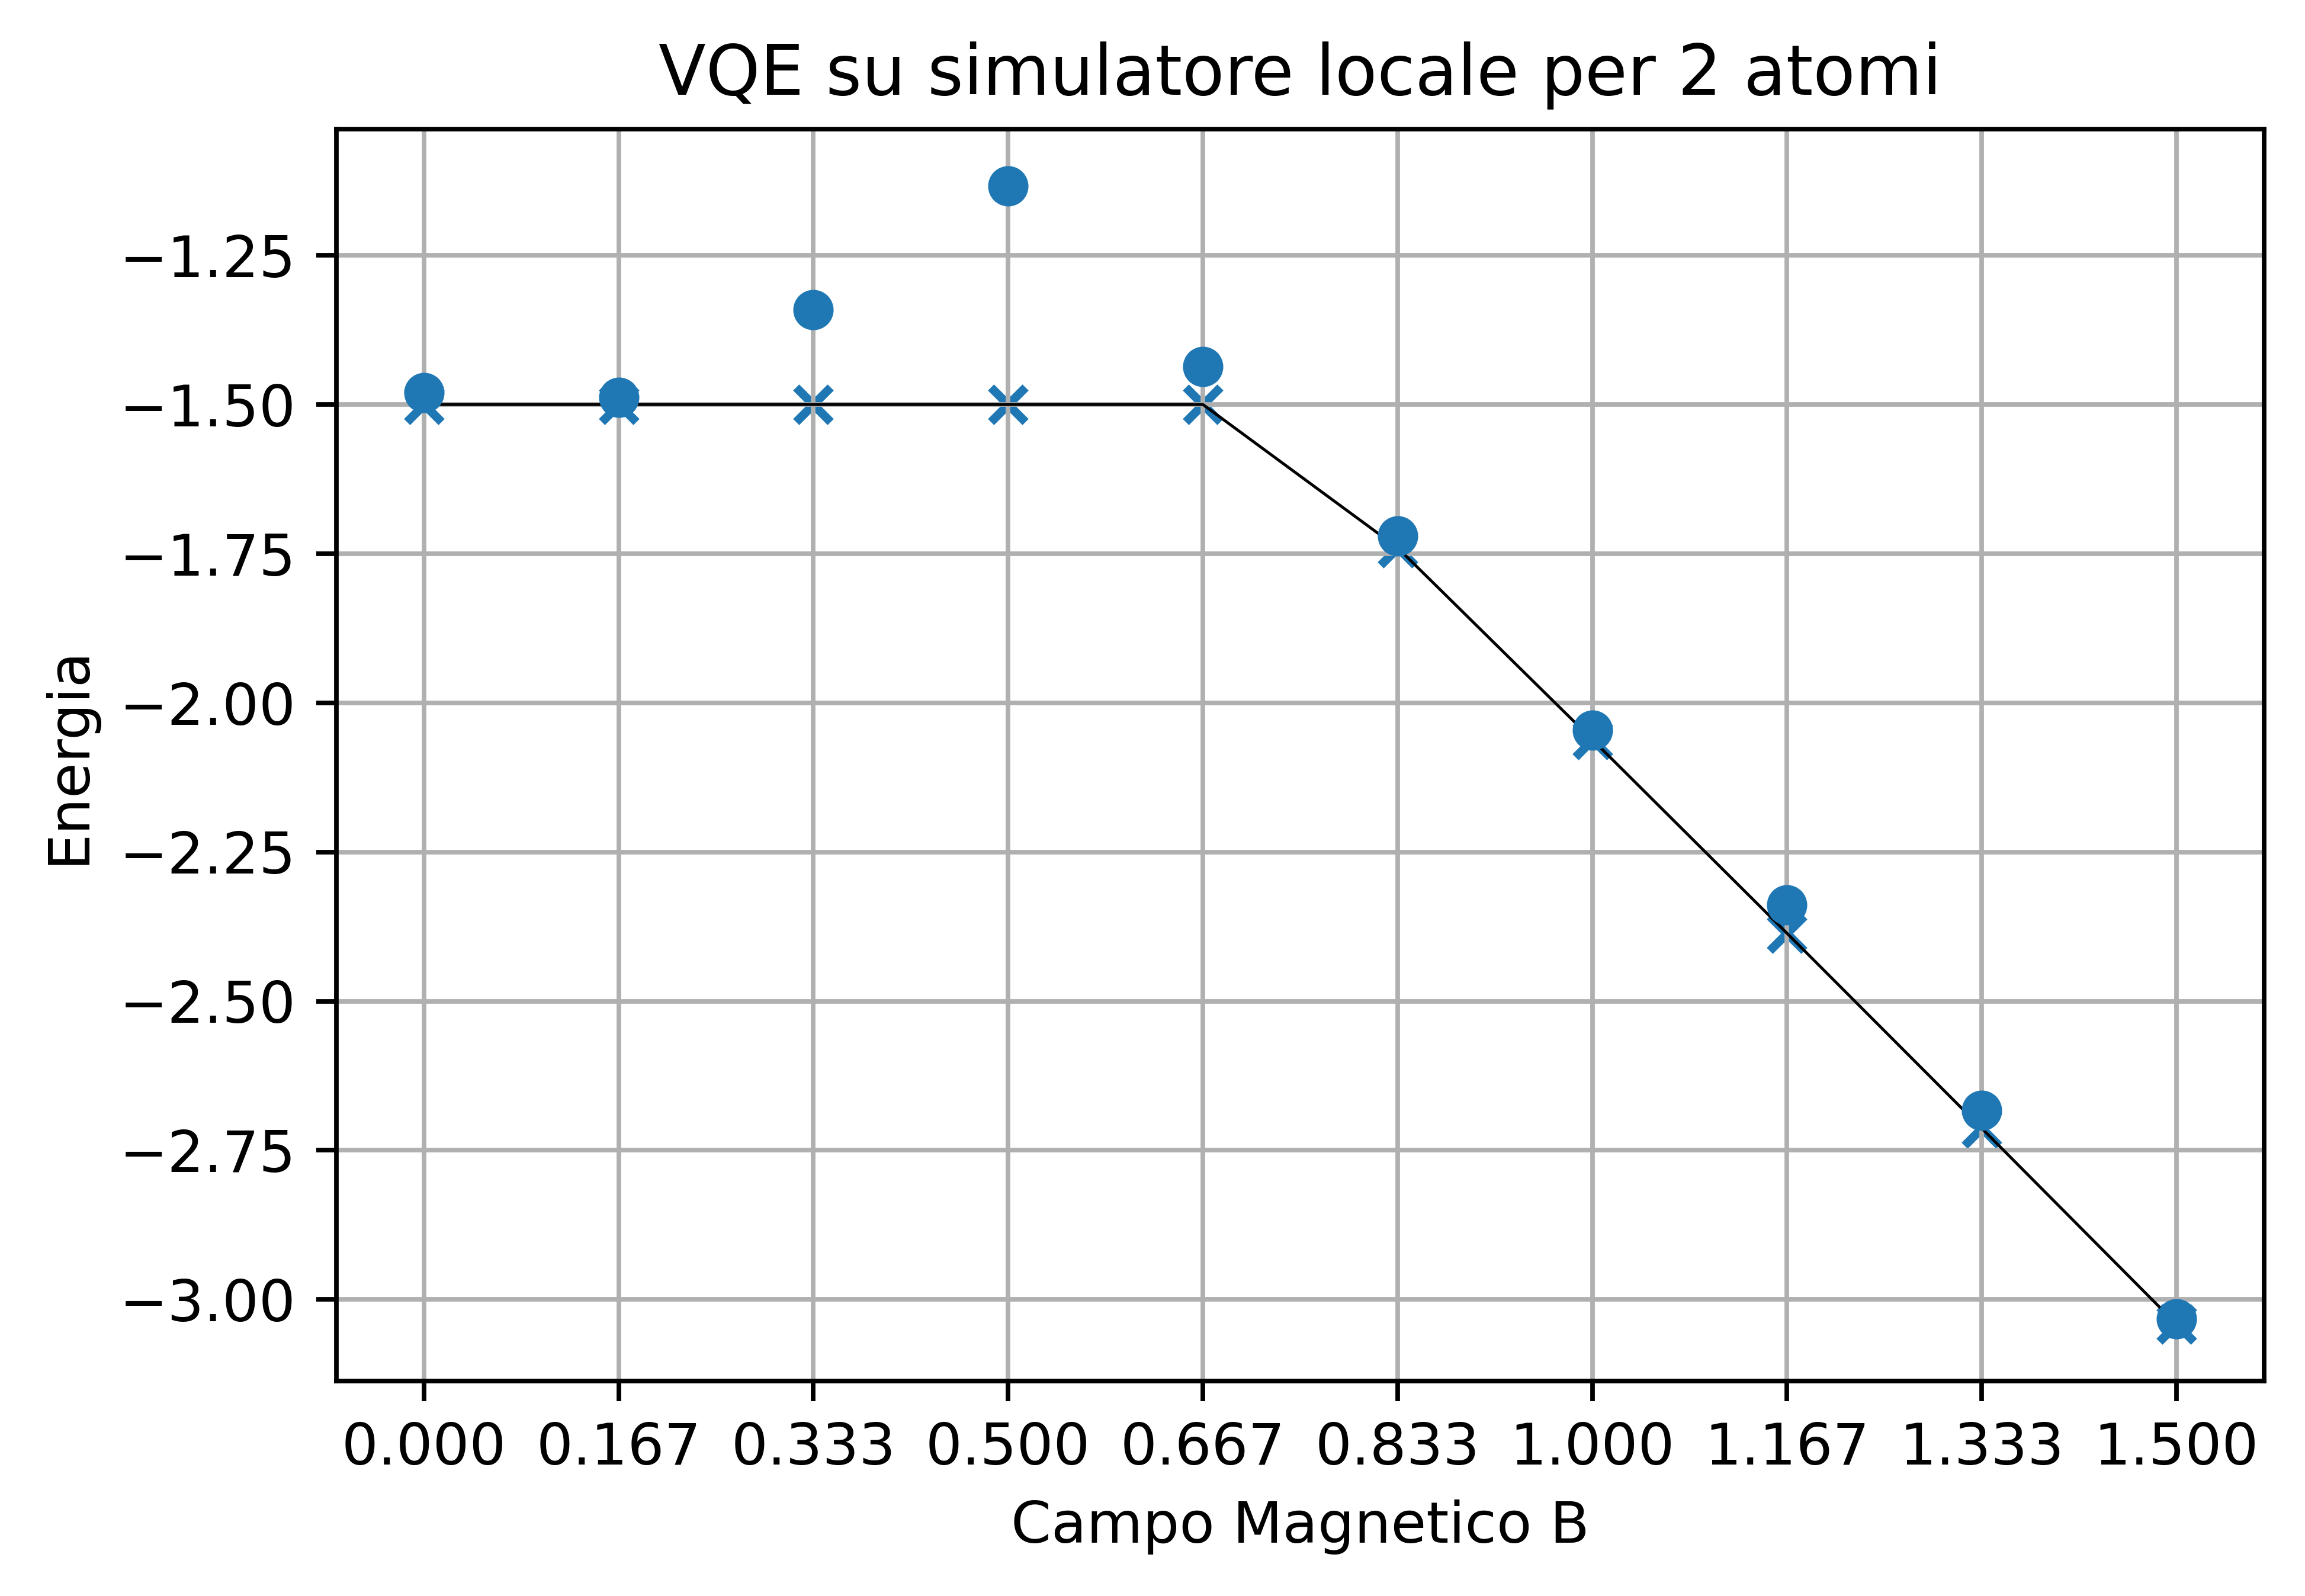

In [90]:
plot_qGS(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

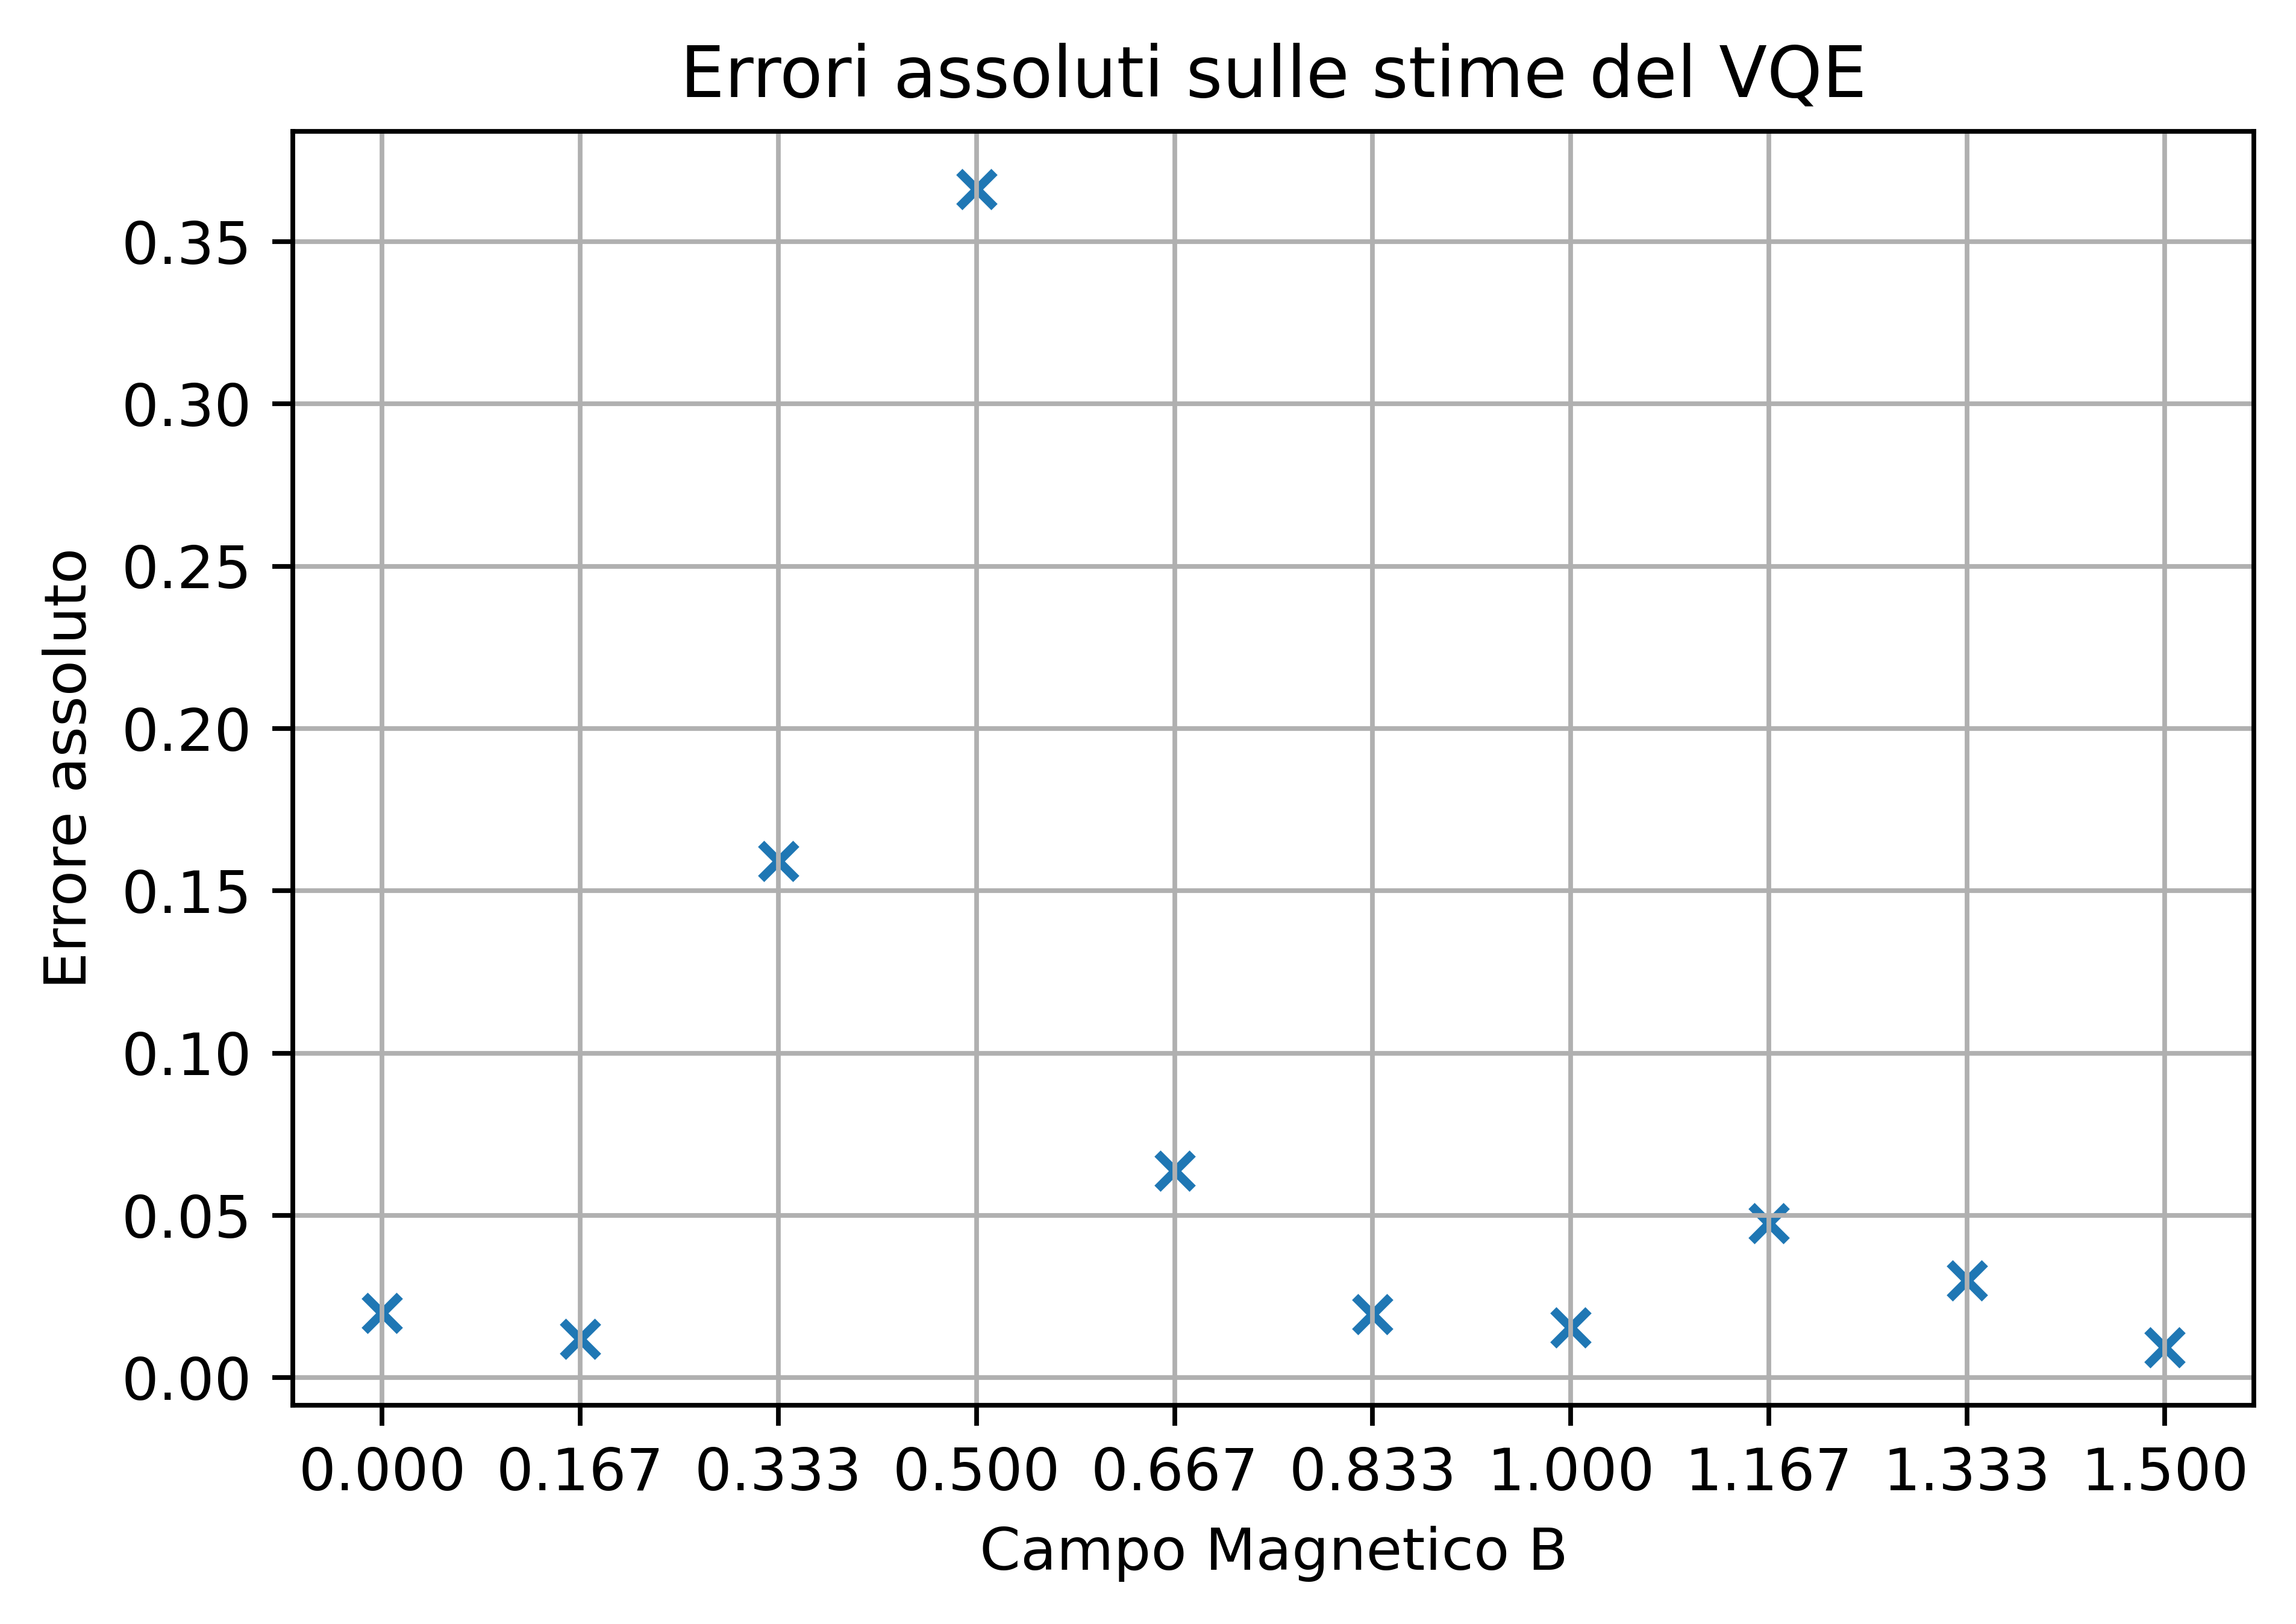

In [91]:
plot_abserr(B,GS1,qGSEigE)

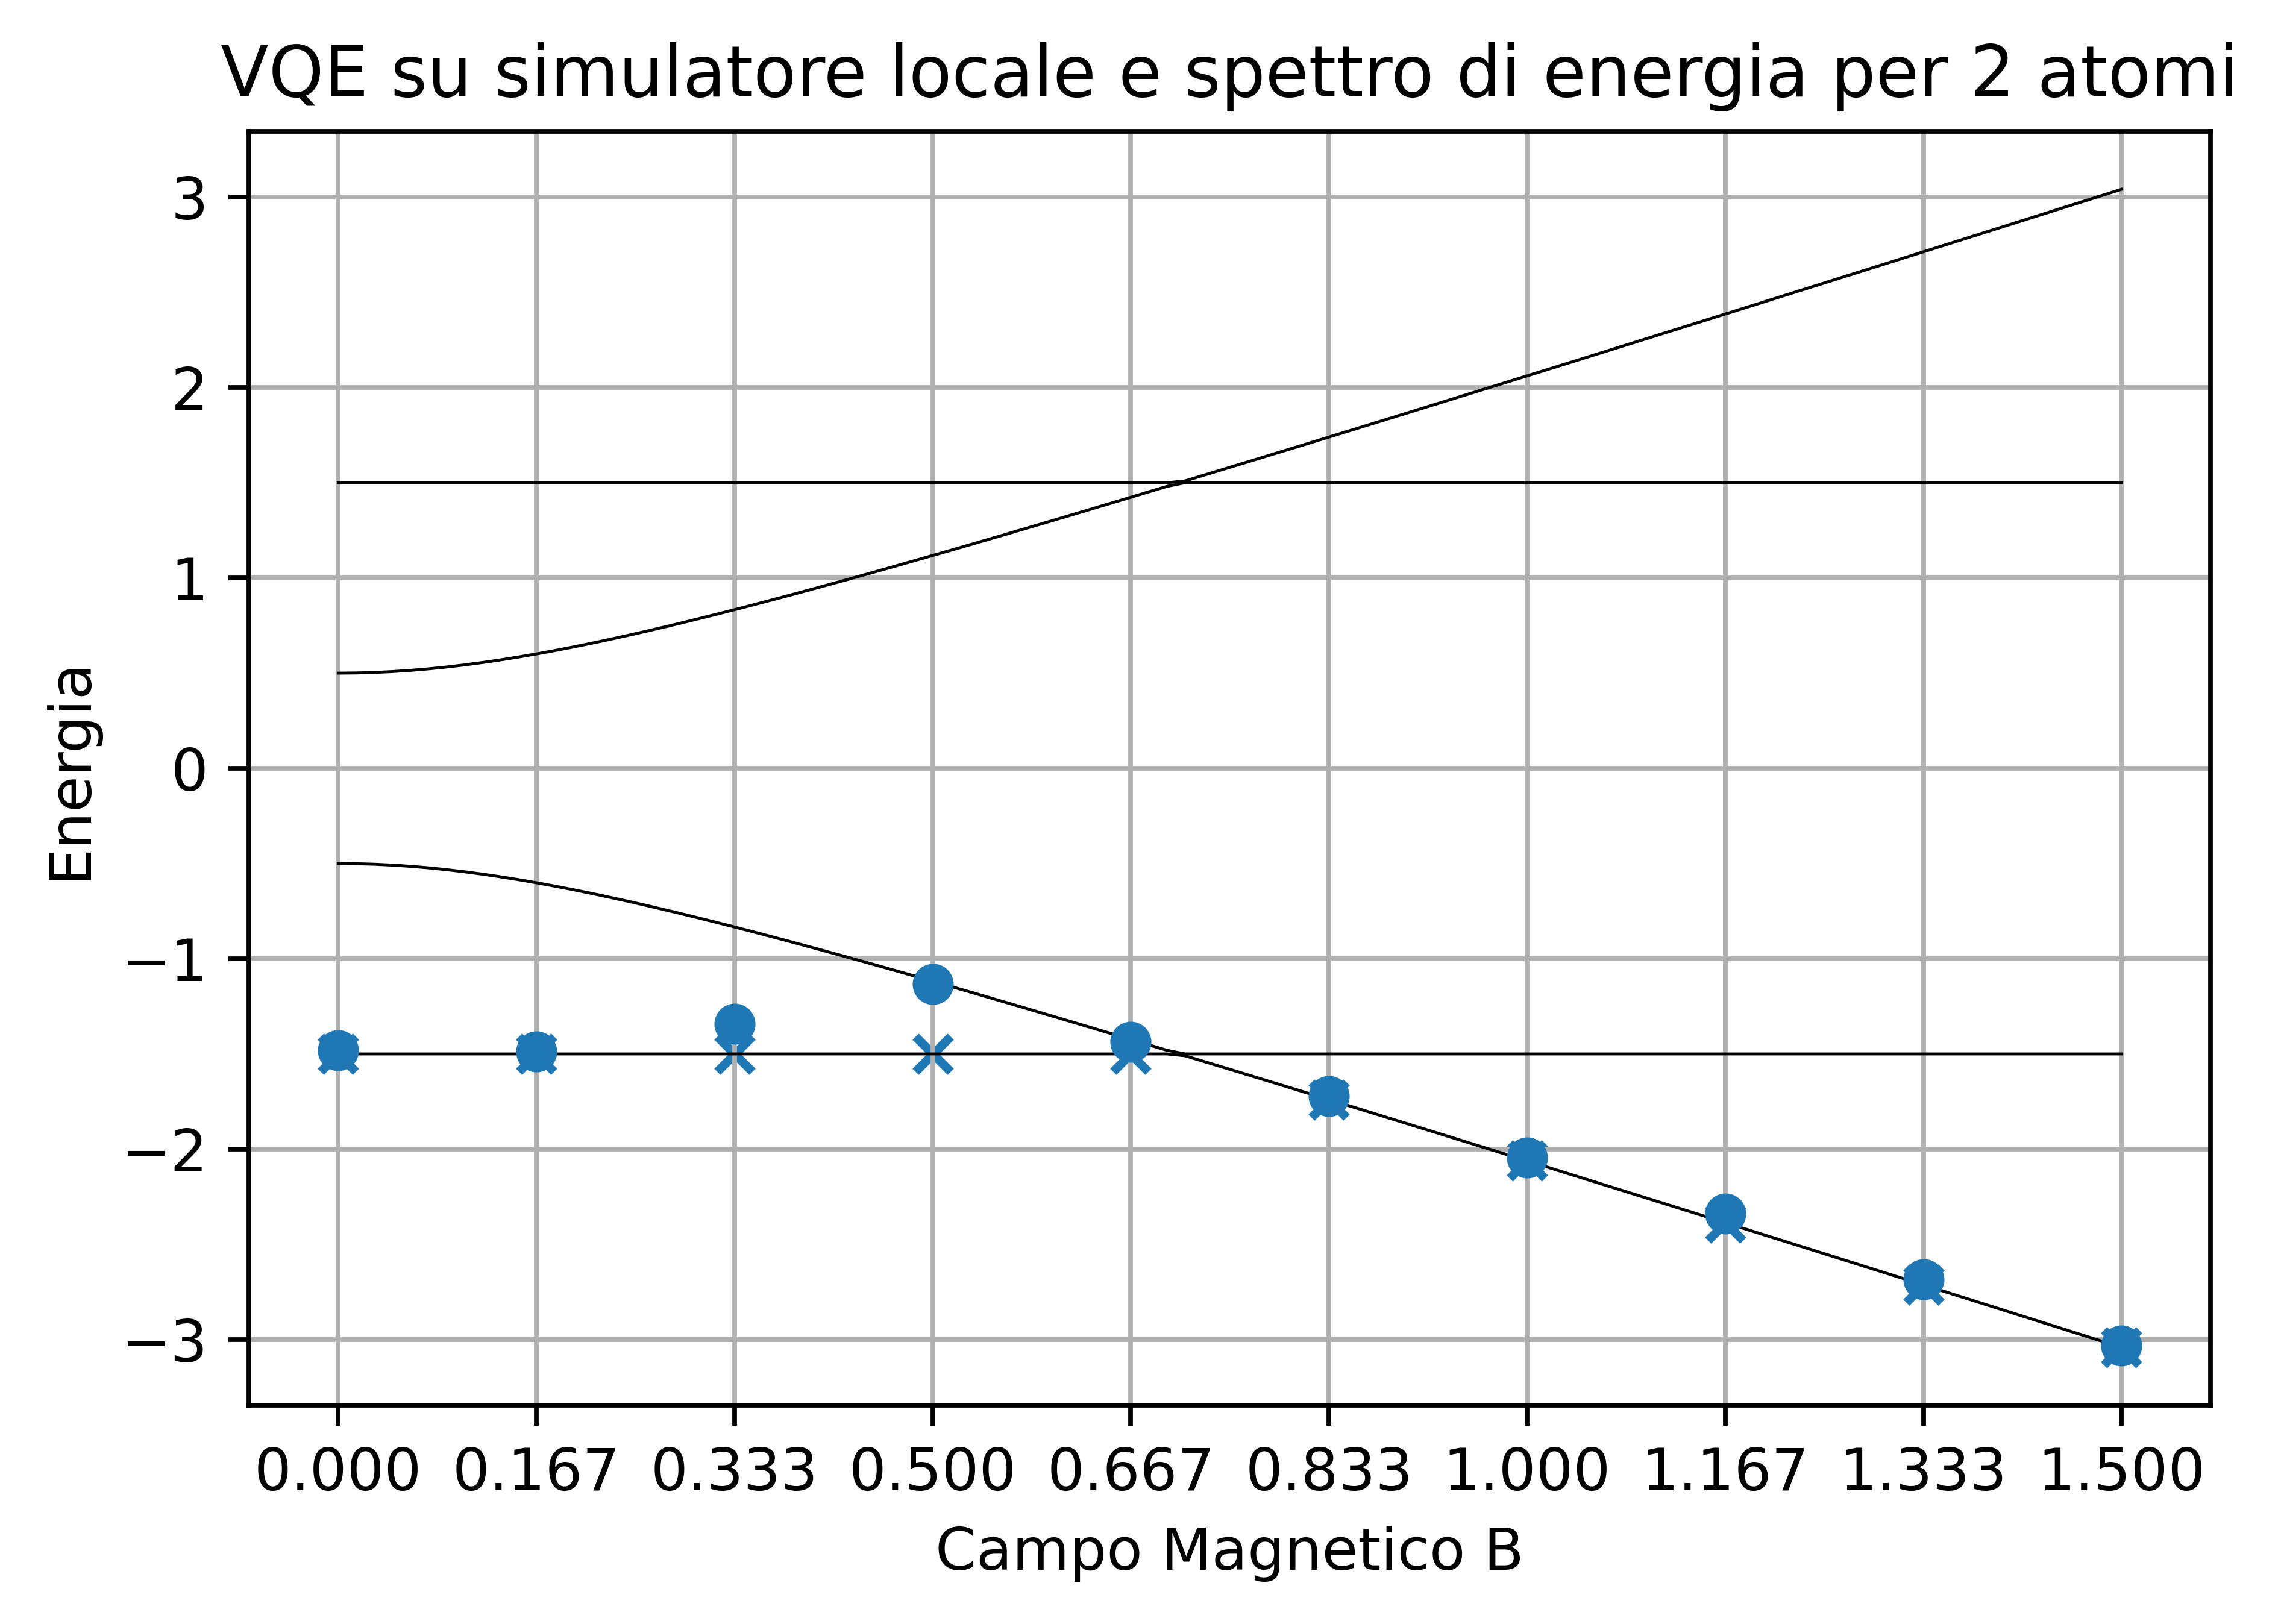

In [92]:
plot_qGS_spectrum(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

$B=0.0:\quad$

<IPython.core.display.Latex object>

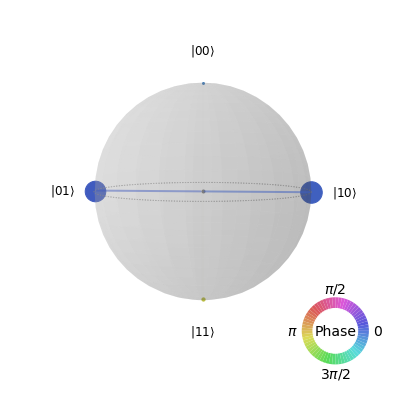

$B=0.167:\quad$

<IPython.core.display.Latex object>

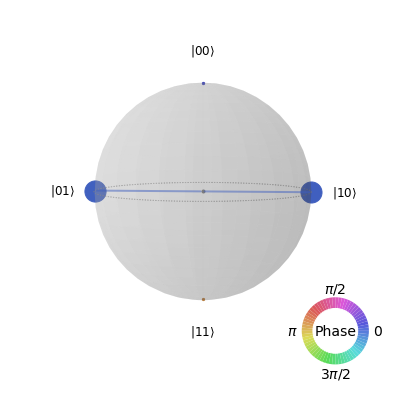

$B=0.333:\quad$

<IPython.core.display.Latex object>

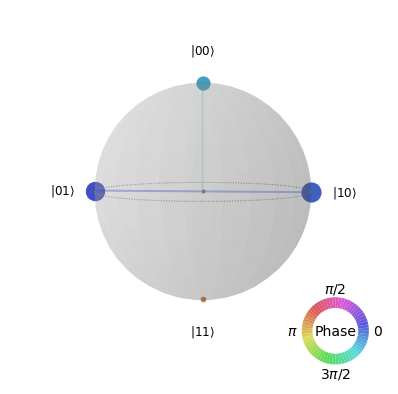

$B=0.5:\quad$

<IPython.core.display.Latex object>

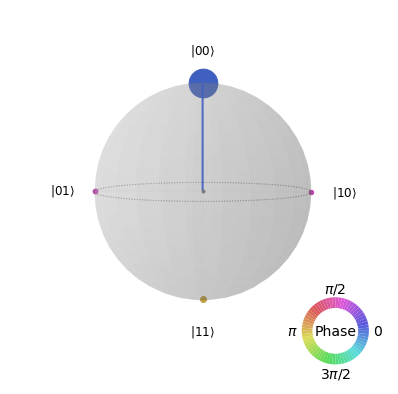

$B=0.667:\quad$

<IPython.core.display.Latex object>

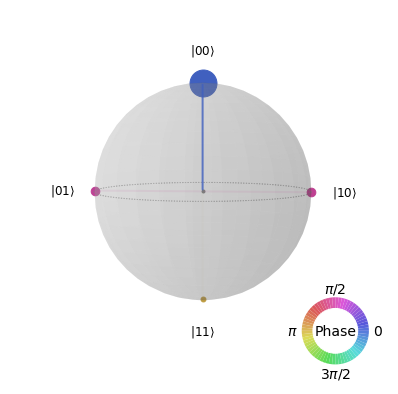

$B=0.833:\quad$

<IPython.core.display.Latex object>

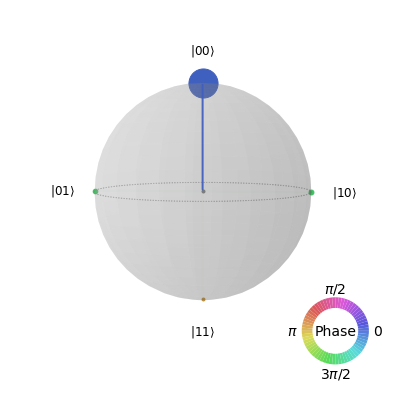

$B=1.0:\quad$

<IPython.core.display.Latex object>

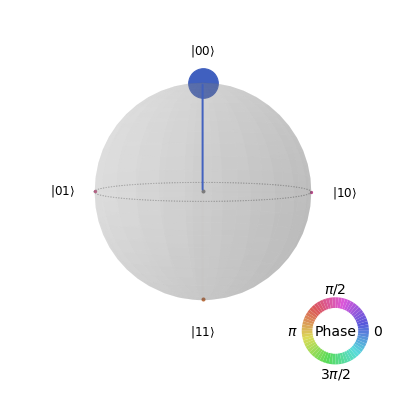

$B=1.167:\quad$

<IPython.core.display.Latex object>

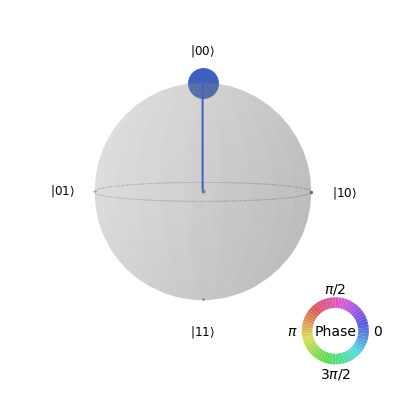

$B=1.333:\quad$

<IPython.core.display.Latex object>

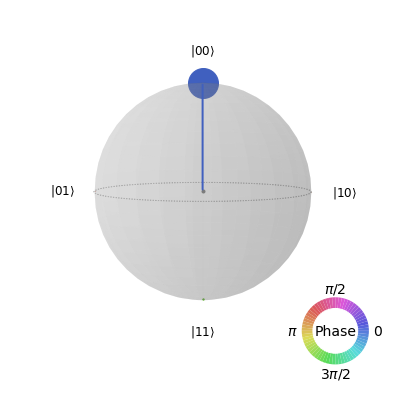

$B=1.5:\quad$

<IPython.core.display.Latex object>

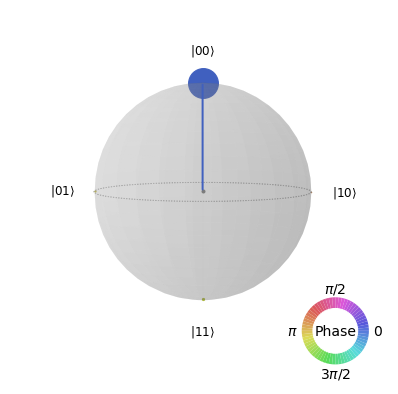

In [112]:
states = [[np.round(abs(j)**2,2)for j in i]for i in qGSstat]
states = [Statevector(entry) for entry in states]
for i in range(len(states)):
    display(Markdown(rf'$B={round(B[i],3)}:\quad$'),array_to_latex(states[i], prefix="\\left|\\psi_0\\right>="))#Statevector(qGSstat[i])
    display(plot_state_qsphere(qGSstat[i]))

### Hardware/Simulator VQE

#### Preparazione

Costruisco la quantum instance e chiamo il VQE con i parametri immessi dall'utente relativamente a:
- strumentazione: hardware, simulatore con/senza rumore;
- numero di <i>shots</i>;
- ottimizzatore: SPSA, COBYLA ecc.:

In [134]:
shots = 8096

optimizer = COBYLA(maxiter=300, tol=0.001, rhobeg=1.0)

measurement_error_mitigation = True

qGSEigE1, meanerr1 = Custom_VQE_diag("noiseless",shots,optimizer)

'Finito.'

#### Risultati

In [188]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE1)):
    print(qGSEigE1[i],meanerr1[i])

Eigenvalues: Mean error:
-0.9035737812911725 0.004813886586859195
-1.1035902503293806 0.00780189037333875
-1.5010293148880105 0.007829423980803076
-2.249711791831357 0.0073923298208379545
-2.9822134387351777 0.009004962037354687


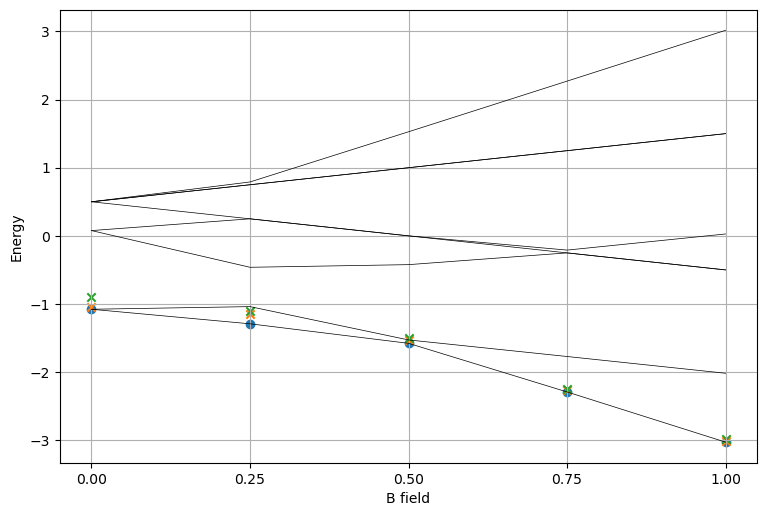

In [189]:
plot_tot([cGSEigE, EigE, qGSEigE, qGSEigE1])

### Caso con 3 atomi

### Soluzione analitica

La hamiltoniana può essere divisa in due parti:
- $\hat H_1 = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma\hat \sigma_y^{(i)}\hat \sigma_y^{(j)}\right)$, che mescola le quaterne $\left|000\right>$, $\left|110\right>$, $\left|101\right>$, $\left|011\right>$ e  $\left|111\right>$, $\left|001\right>$, $\left|010\right>$, $\left|100\right>$ della base computazionale;
- $\hat H_2 = - B \sum_{i=1}^n \hat\sigma_z^{(i)}$, di cui tutti gli stati della base computazionale sono autostati.

Allora basta studiare come si mescolano le due quaterne, questa volta, individuate da $\hat H_1$ e si trovano gli autovalori di $\hat H$:
- $E=-(\pm B+J(1+\gamma))\pm2\sqrt{J^2(1+\gamma^2-\gamma)^2+B^2\pm BJ(1+\gamma)}$;
- $E=\pm B + J(1+\gamma)$.

A questo punto, per i diversi valori di $J$ e $B$ basta vedere quale dei valori di $E$ è il minimo, ma non l'abbiamo fatto a mano perché dipende anche dal segno dei due parametri. Sicuramente si può escludere sempre $E=-(\pm B+J(1+\gamma))+2\sqrt{J^2(1+\gamma^2-\gamma)^2+B^2\pm BJ(1+\gamma)}$, mentre gli altri autovalori possono tutti essere quelli di minimo in diverse condizioni.

In [115]:
cH = []
Natoms = 3 #Cambiamo numero atomi
J = 1./Natoms
gy = 2
gz = 0
Bmin=0
Bmax=1.5
Neval=5
B = np.linspace(Bmin,Bmax,Neval).tolist()

In [116]:
def compGS1(J,gy,gz,B):
    a = B + J * (1. + gy)
    c = sqrt( J**2 * (1+gy**2-gy) + B**2 - B*J*(1+gy) )
    energy = - a - 2*c
    return energy

def compGS2(J,gy,gz,B):
    a = - B + J * (1. + gy)
    c = sqrt( J**2 * (1+gy**2-gy) + B**2 + B*J*(1+gy) )
    energy = - a - 2*c
    return energy

In [117]:
GS1 = [min(compGS1(J,gy,gz,i),compGS2(J,gy,gz,i),i+J*(1+gy),-i+J*(1+gy)) for i in B]

### Diagonalizzazione computazionale classica

In [118]:
import numpy as np
from qiskit.opflow import X, Y, Z, I

def Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction

    #initialize 0-dimensional Operators
    field=Operator([0])
    spin=Operator([0])
    
    #cycle over all qubits
    for i in range(Natoms):
       
        #Adds the spin field interaction for each atom
        field=(field^I)-(B*((I^i)^Z))
        spin=spin^I
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spin -= ( J * ((I^j)^X^(I^(i-j-1))^X))
            spin -= (J*gy*((I^j)^Y^(I^(i-j-1))^Y))
            
    return(spin+field)

#### Algoritmo per risoluzione classica

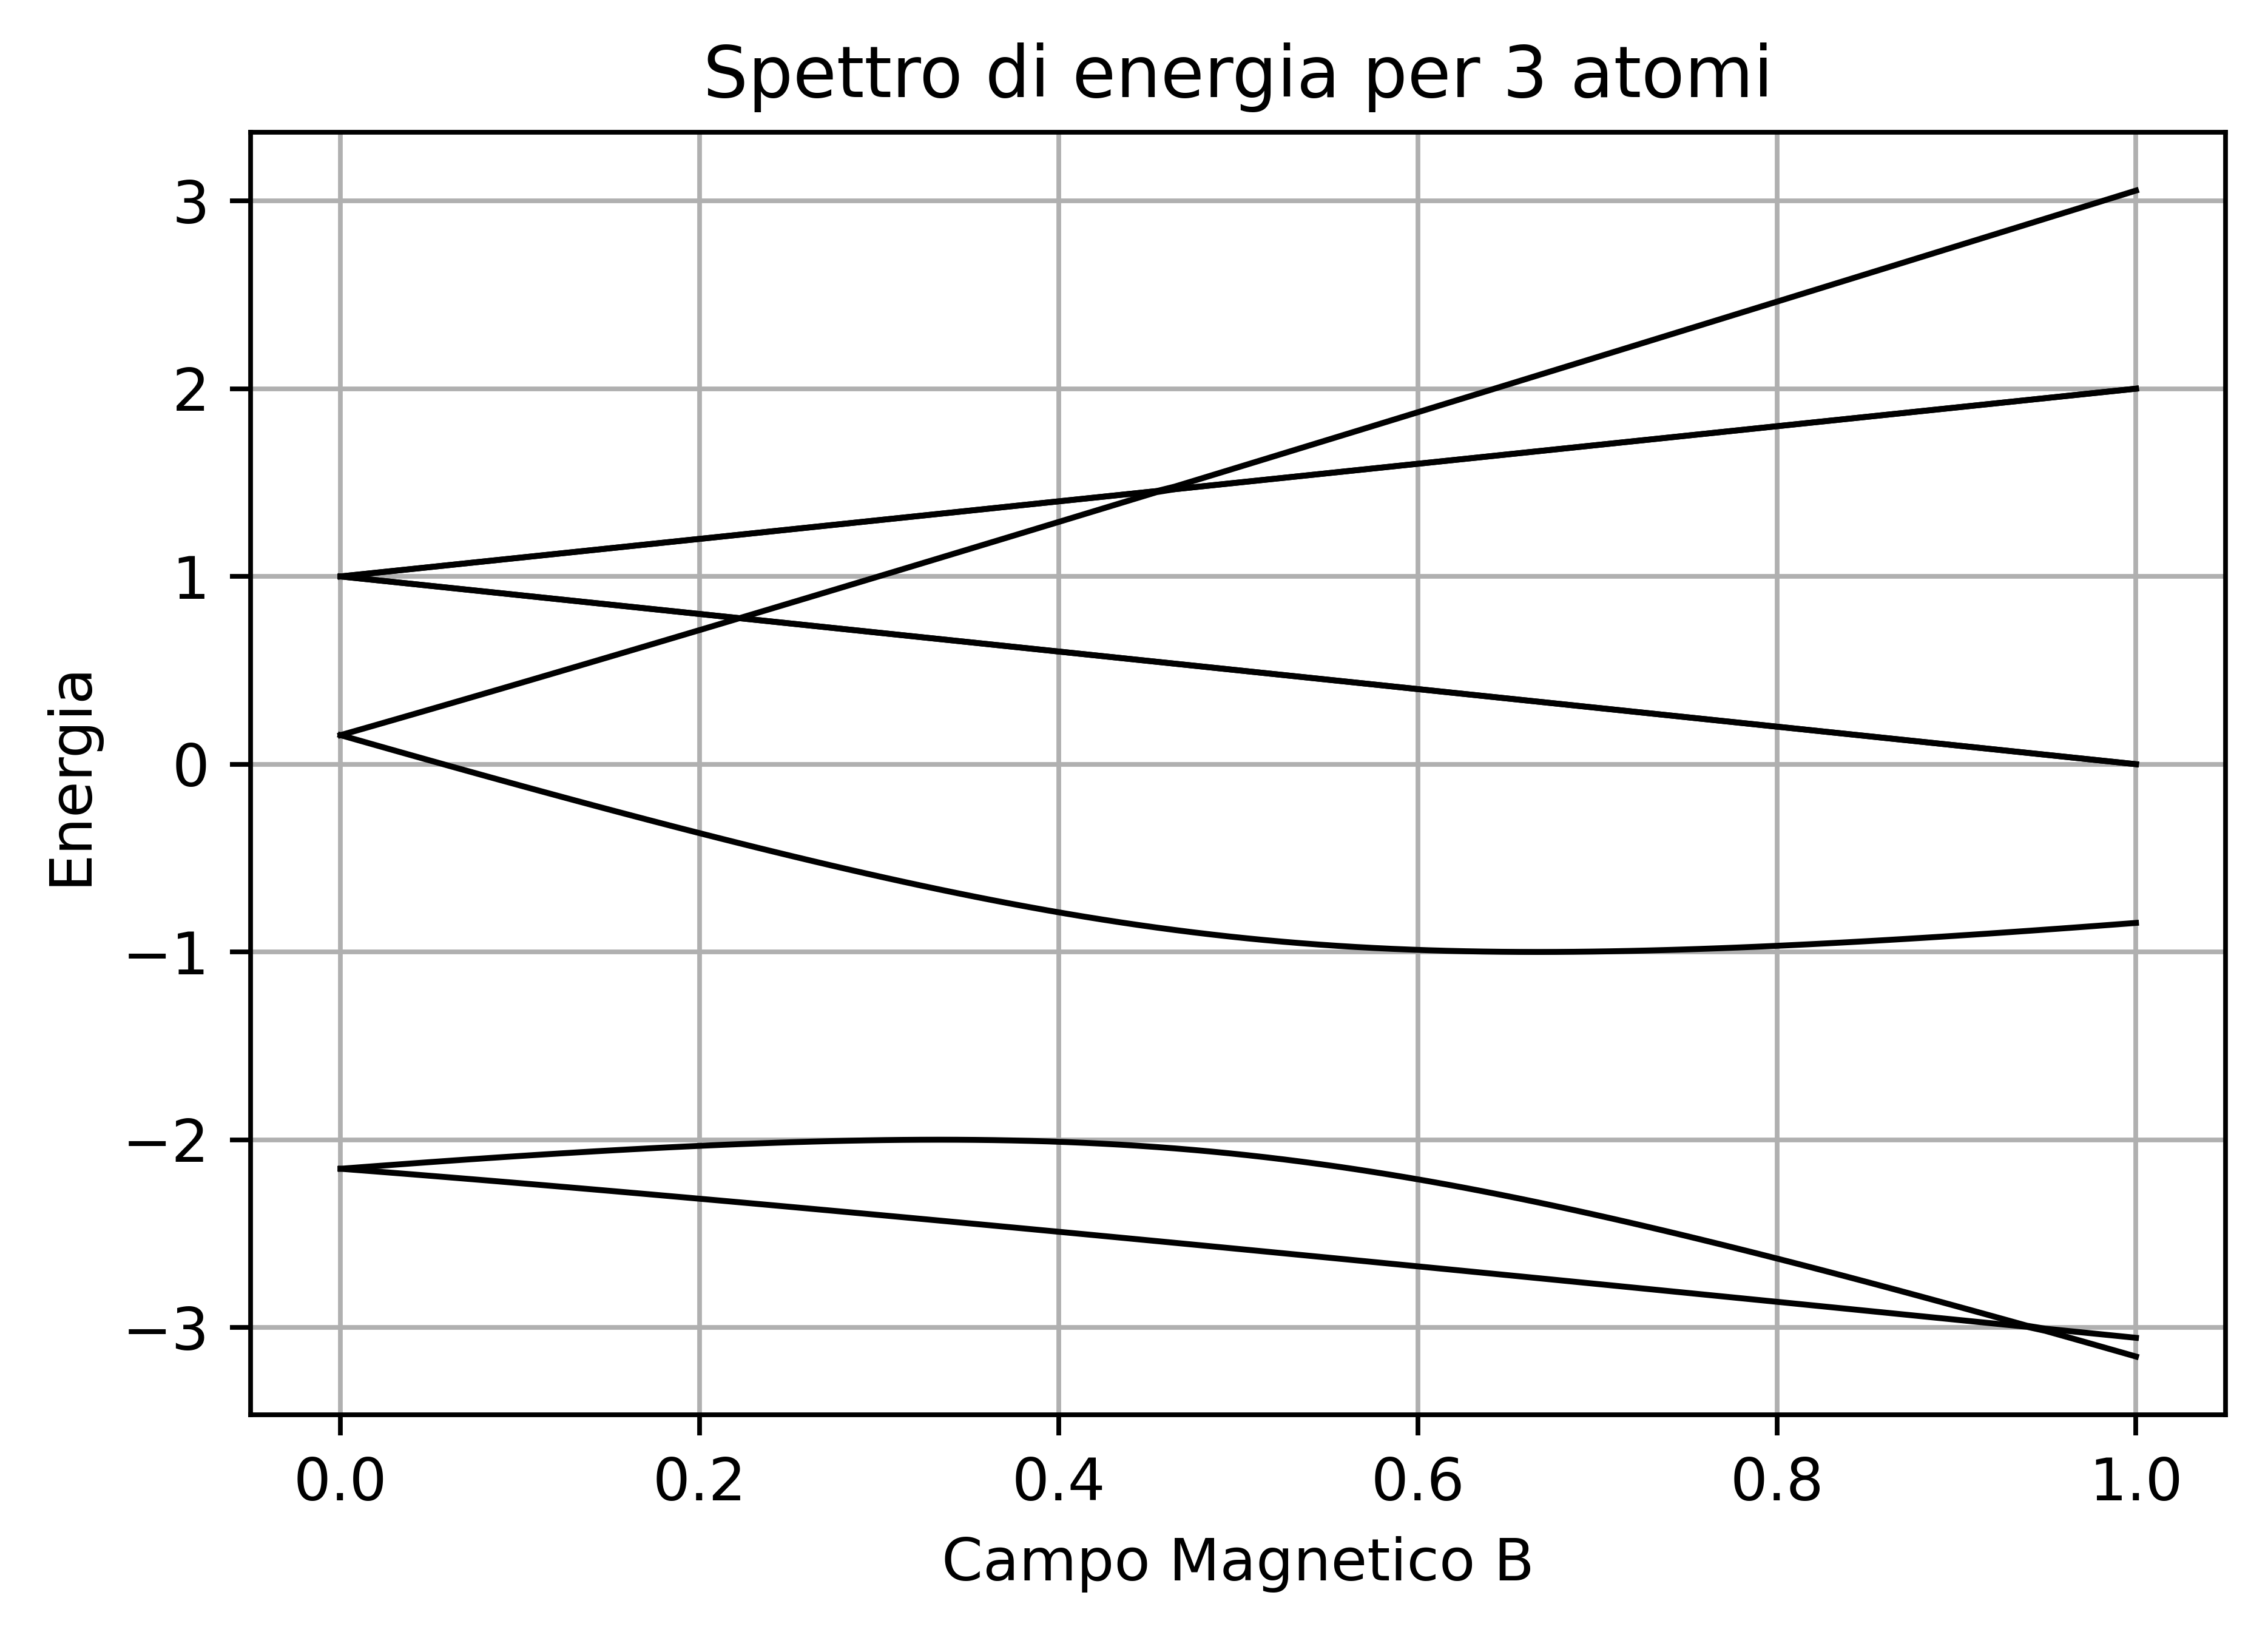

In [121]:
spectrum_class(0.,1.,100,Natoms,J,gy,gz)

### Diagonalizzazione quantistica con il VQE locale

In [122]:
def Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B):
    
    #initialize 0-dimensional Operators
    init = primitive_ops.PauliOp(Pauli('I'*Natoms),0)
    field,spins = [init]*2
    
    #cycle over all qubits
    for i in range(Natoms):
    
        #Adds the spin field interaction for each atom
        field -= primitive_ops.PauliOp(Pauli('I'*i+'Z'+'I'*(Natoms-i-1)),B)
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'X'+'I'*(i-j-1)+'X'+'I'*(Natoms-i-1)),J)
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'Y'+'I'*(i-j-1)+'Y'+'I'*(Natoms-i-1)),J*gy)

    return (field+spins)

qH = []
for k in range(len(B)):
    qH.append(Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k]))

#### Definizione dell'ansatz

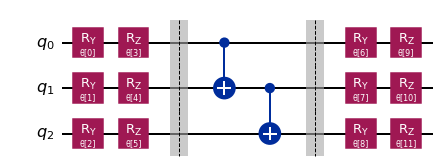

In [125]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

#### Scelta dell'ottimizzatore

In [126]:
optimizer = COBYLA(maxiter=400)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

#### Simulazione locale della VQE

In [127]:
local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),
                callback=callback)

qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

### Risultati

In [538]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-1.051358941359308 0.0
-1.1604302551373613 0.0
-1.5090622287409758 0.0
-2.2533458563347906 0.0
-3.005096209784959 0.0


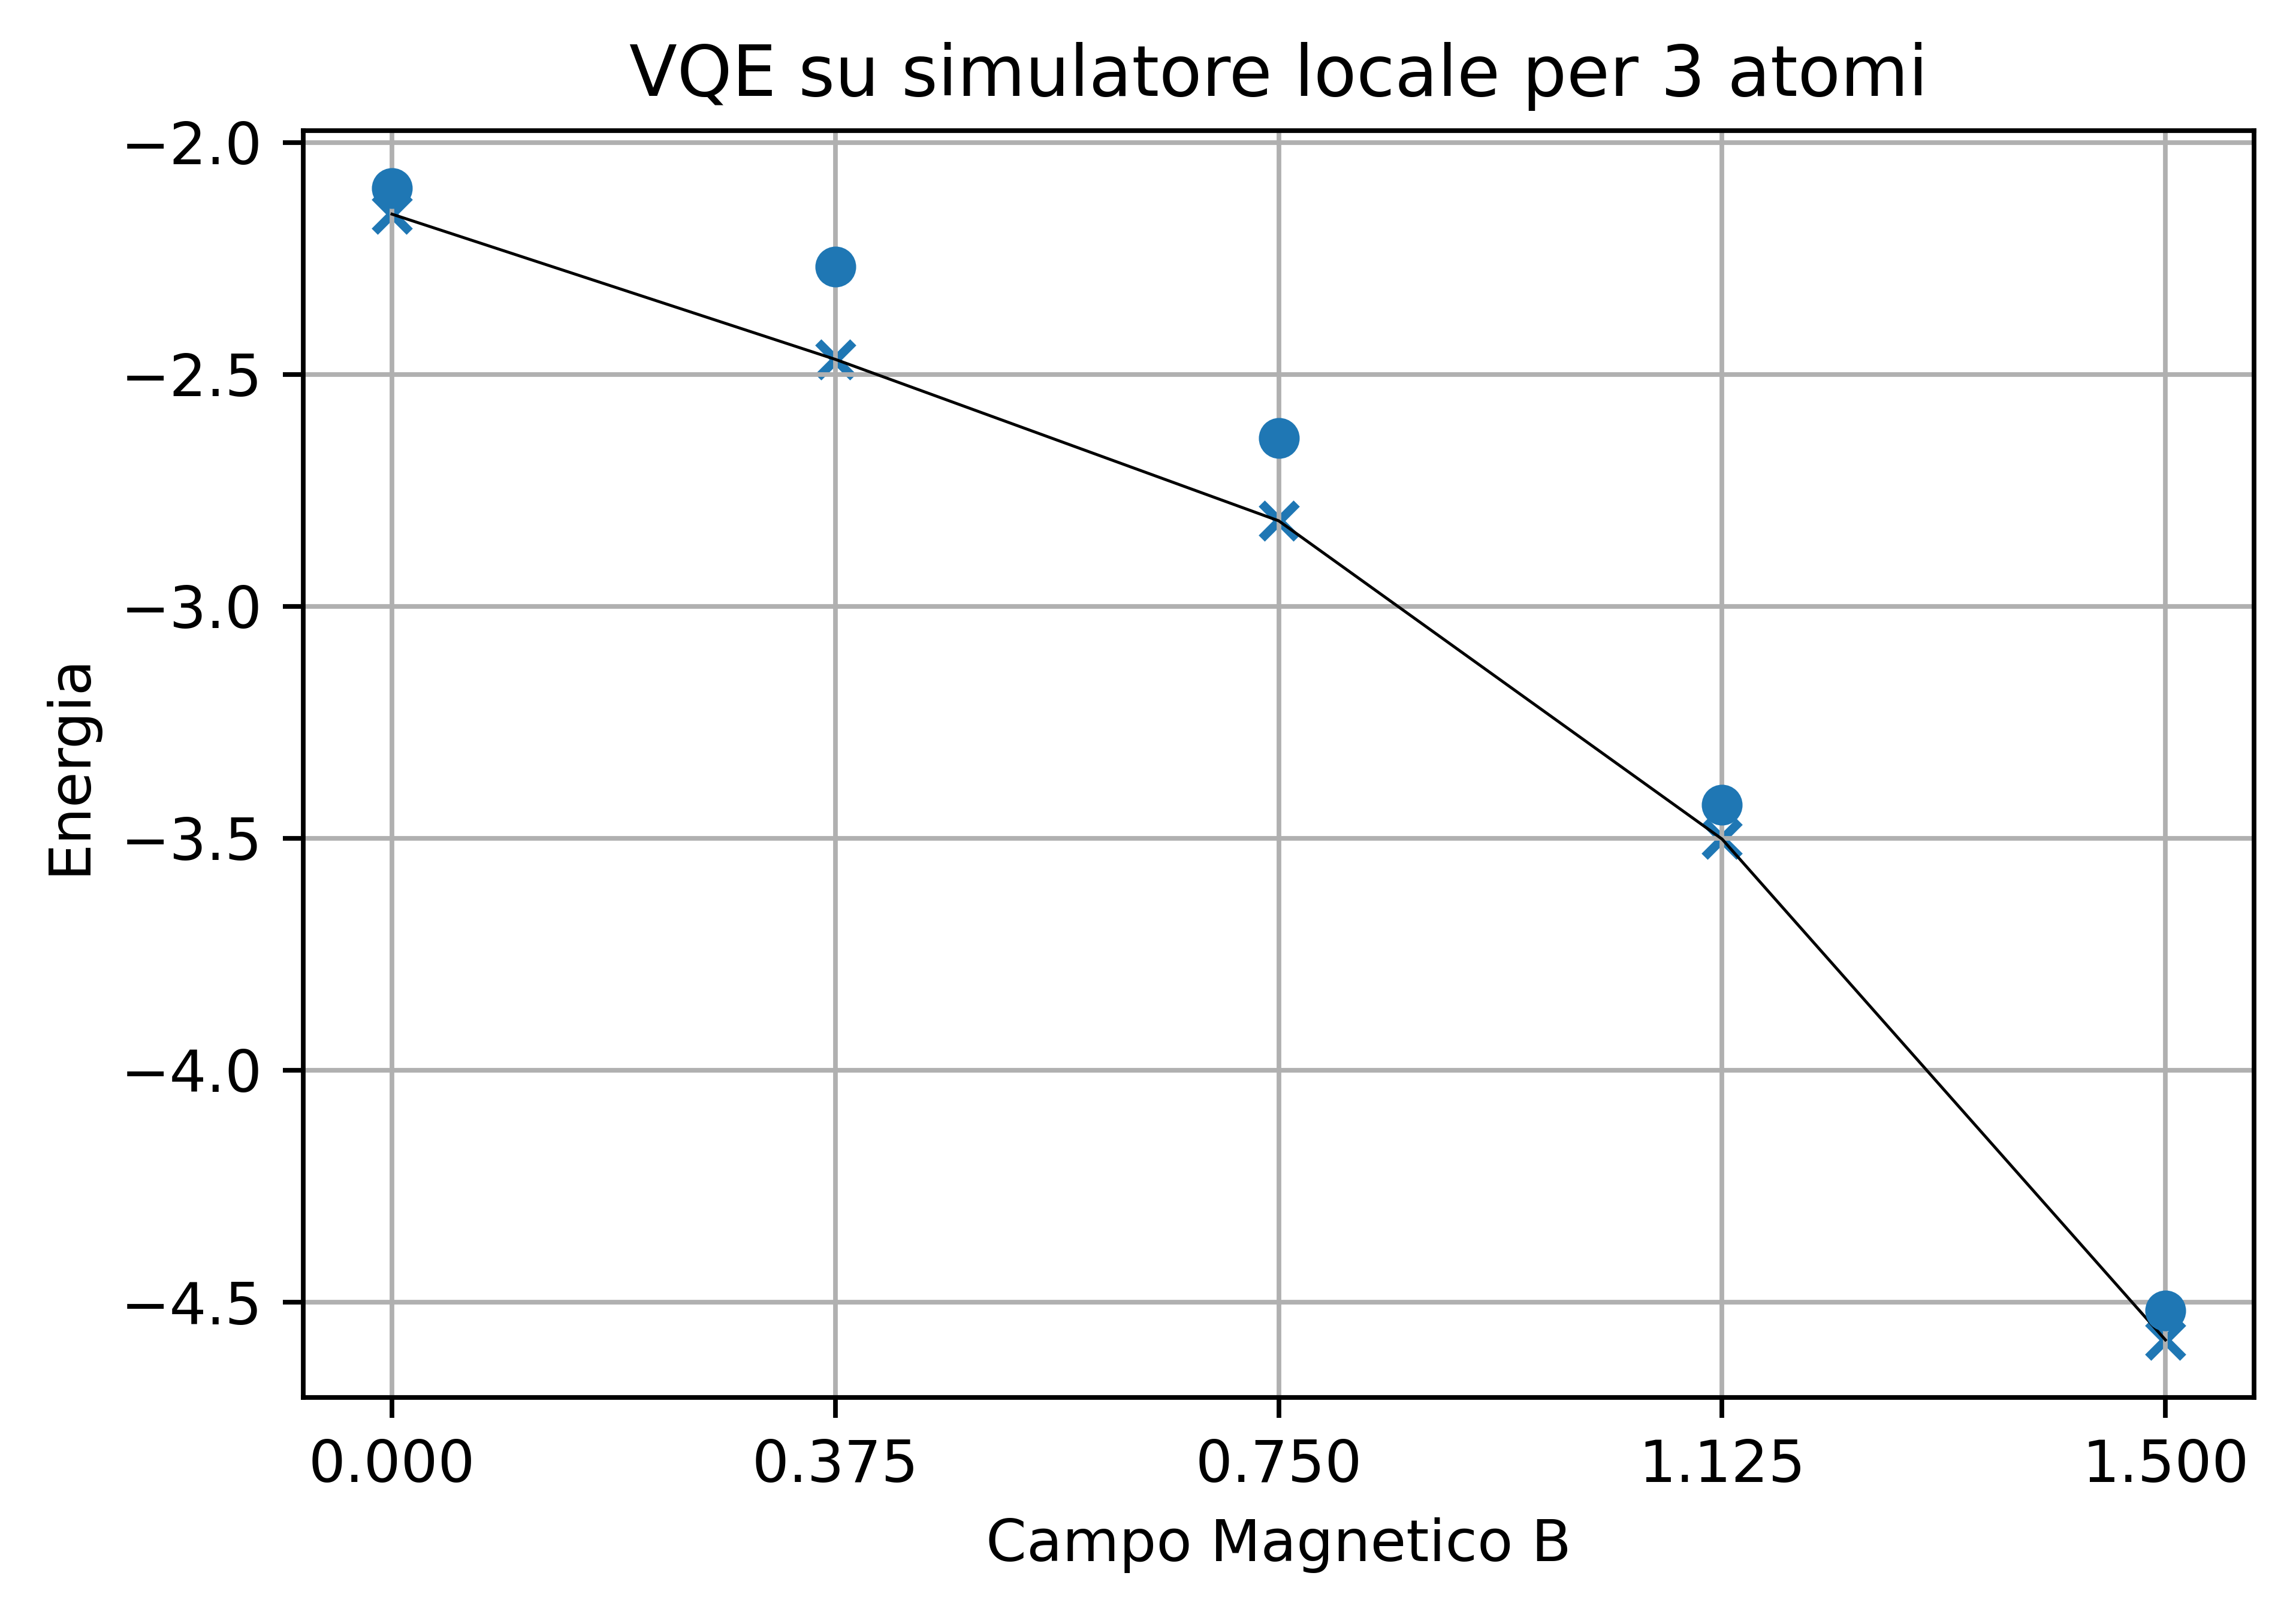

In [128]:
plot_qGS(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

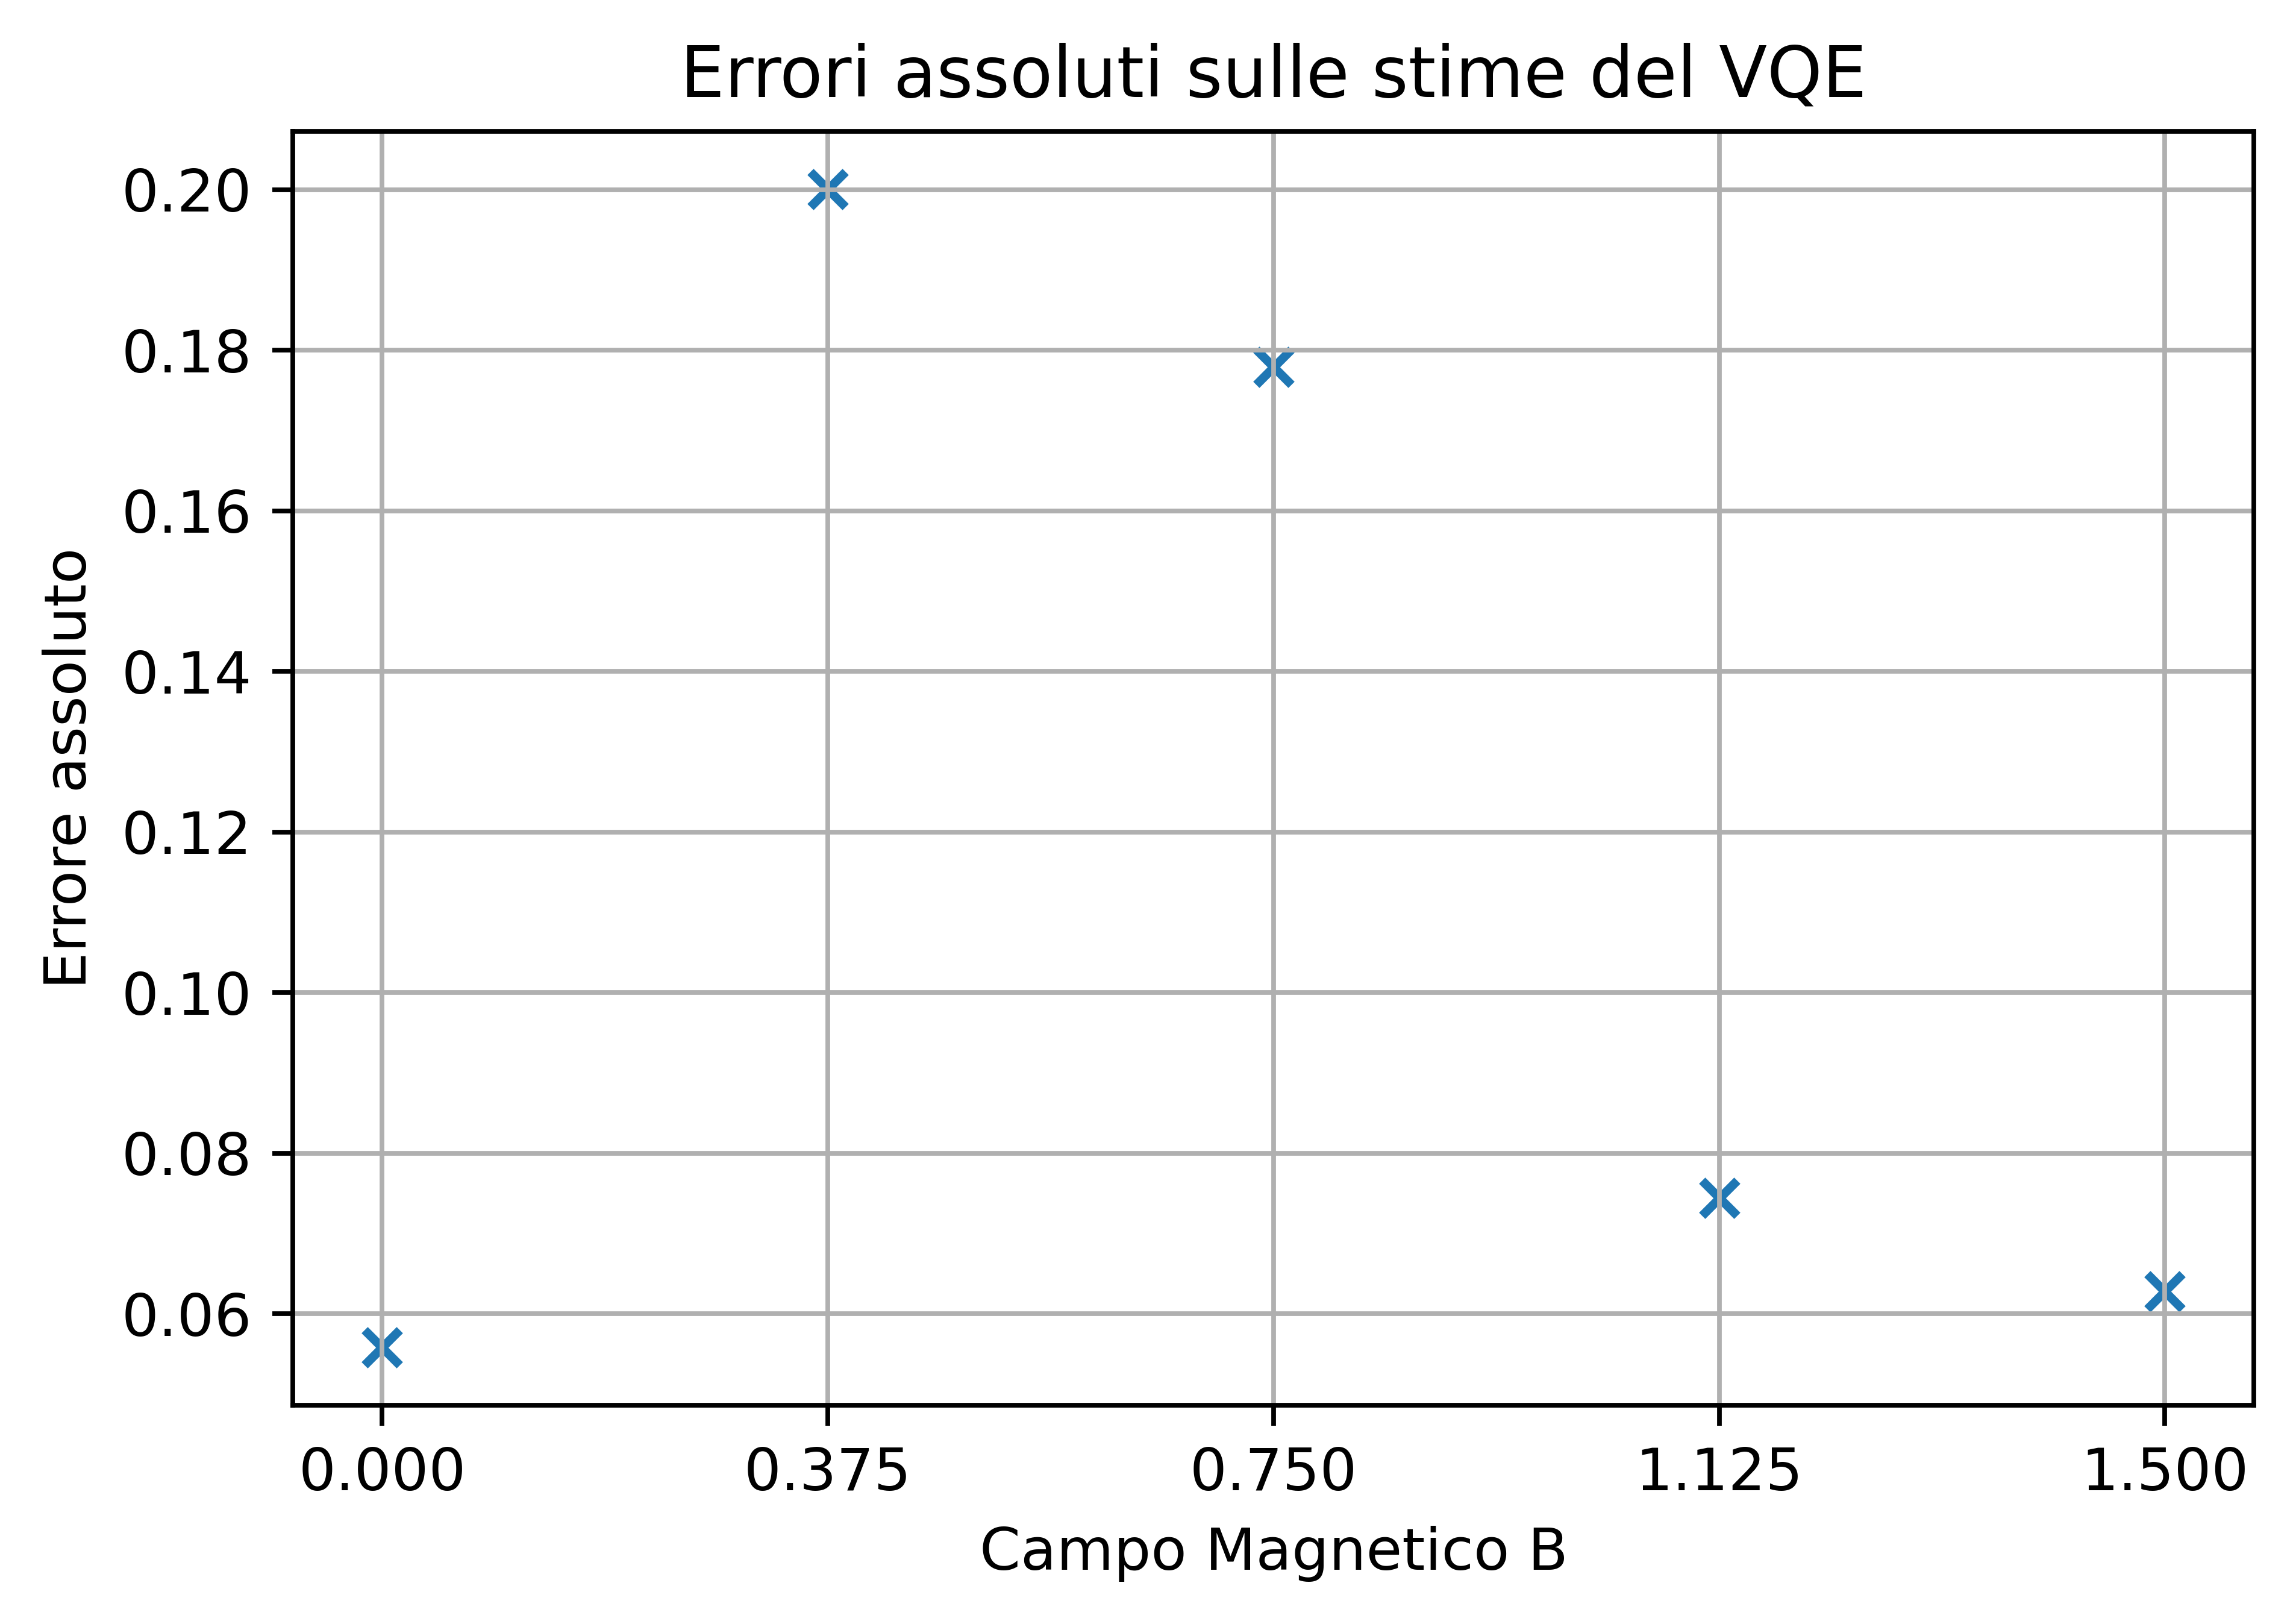

In [130]:
plot_abserr(B,GS1,qGSEigE)

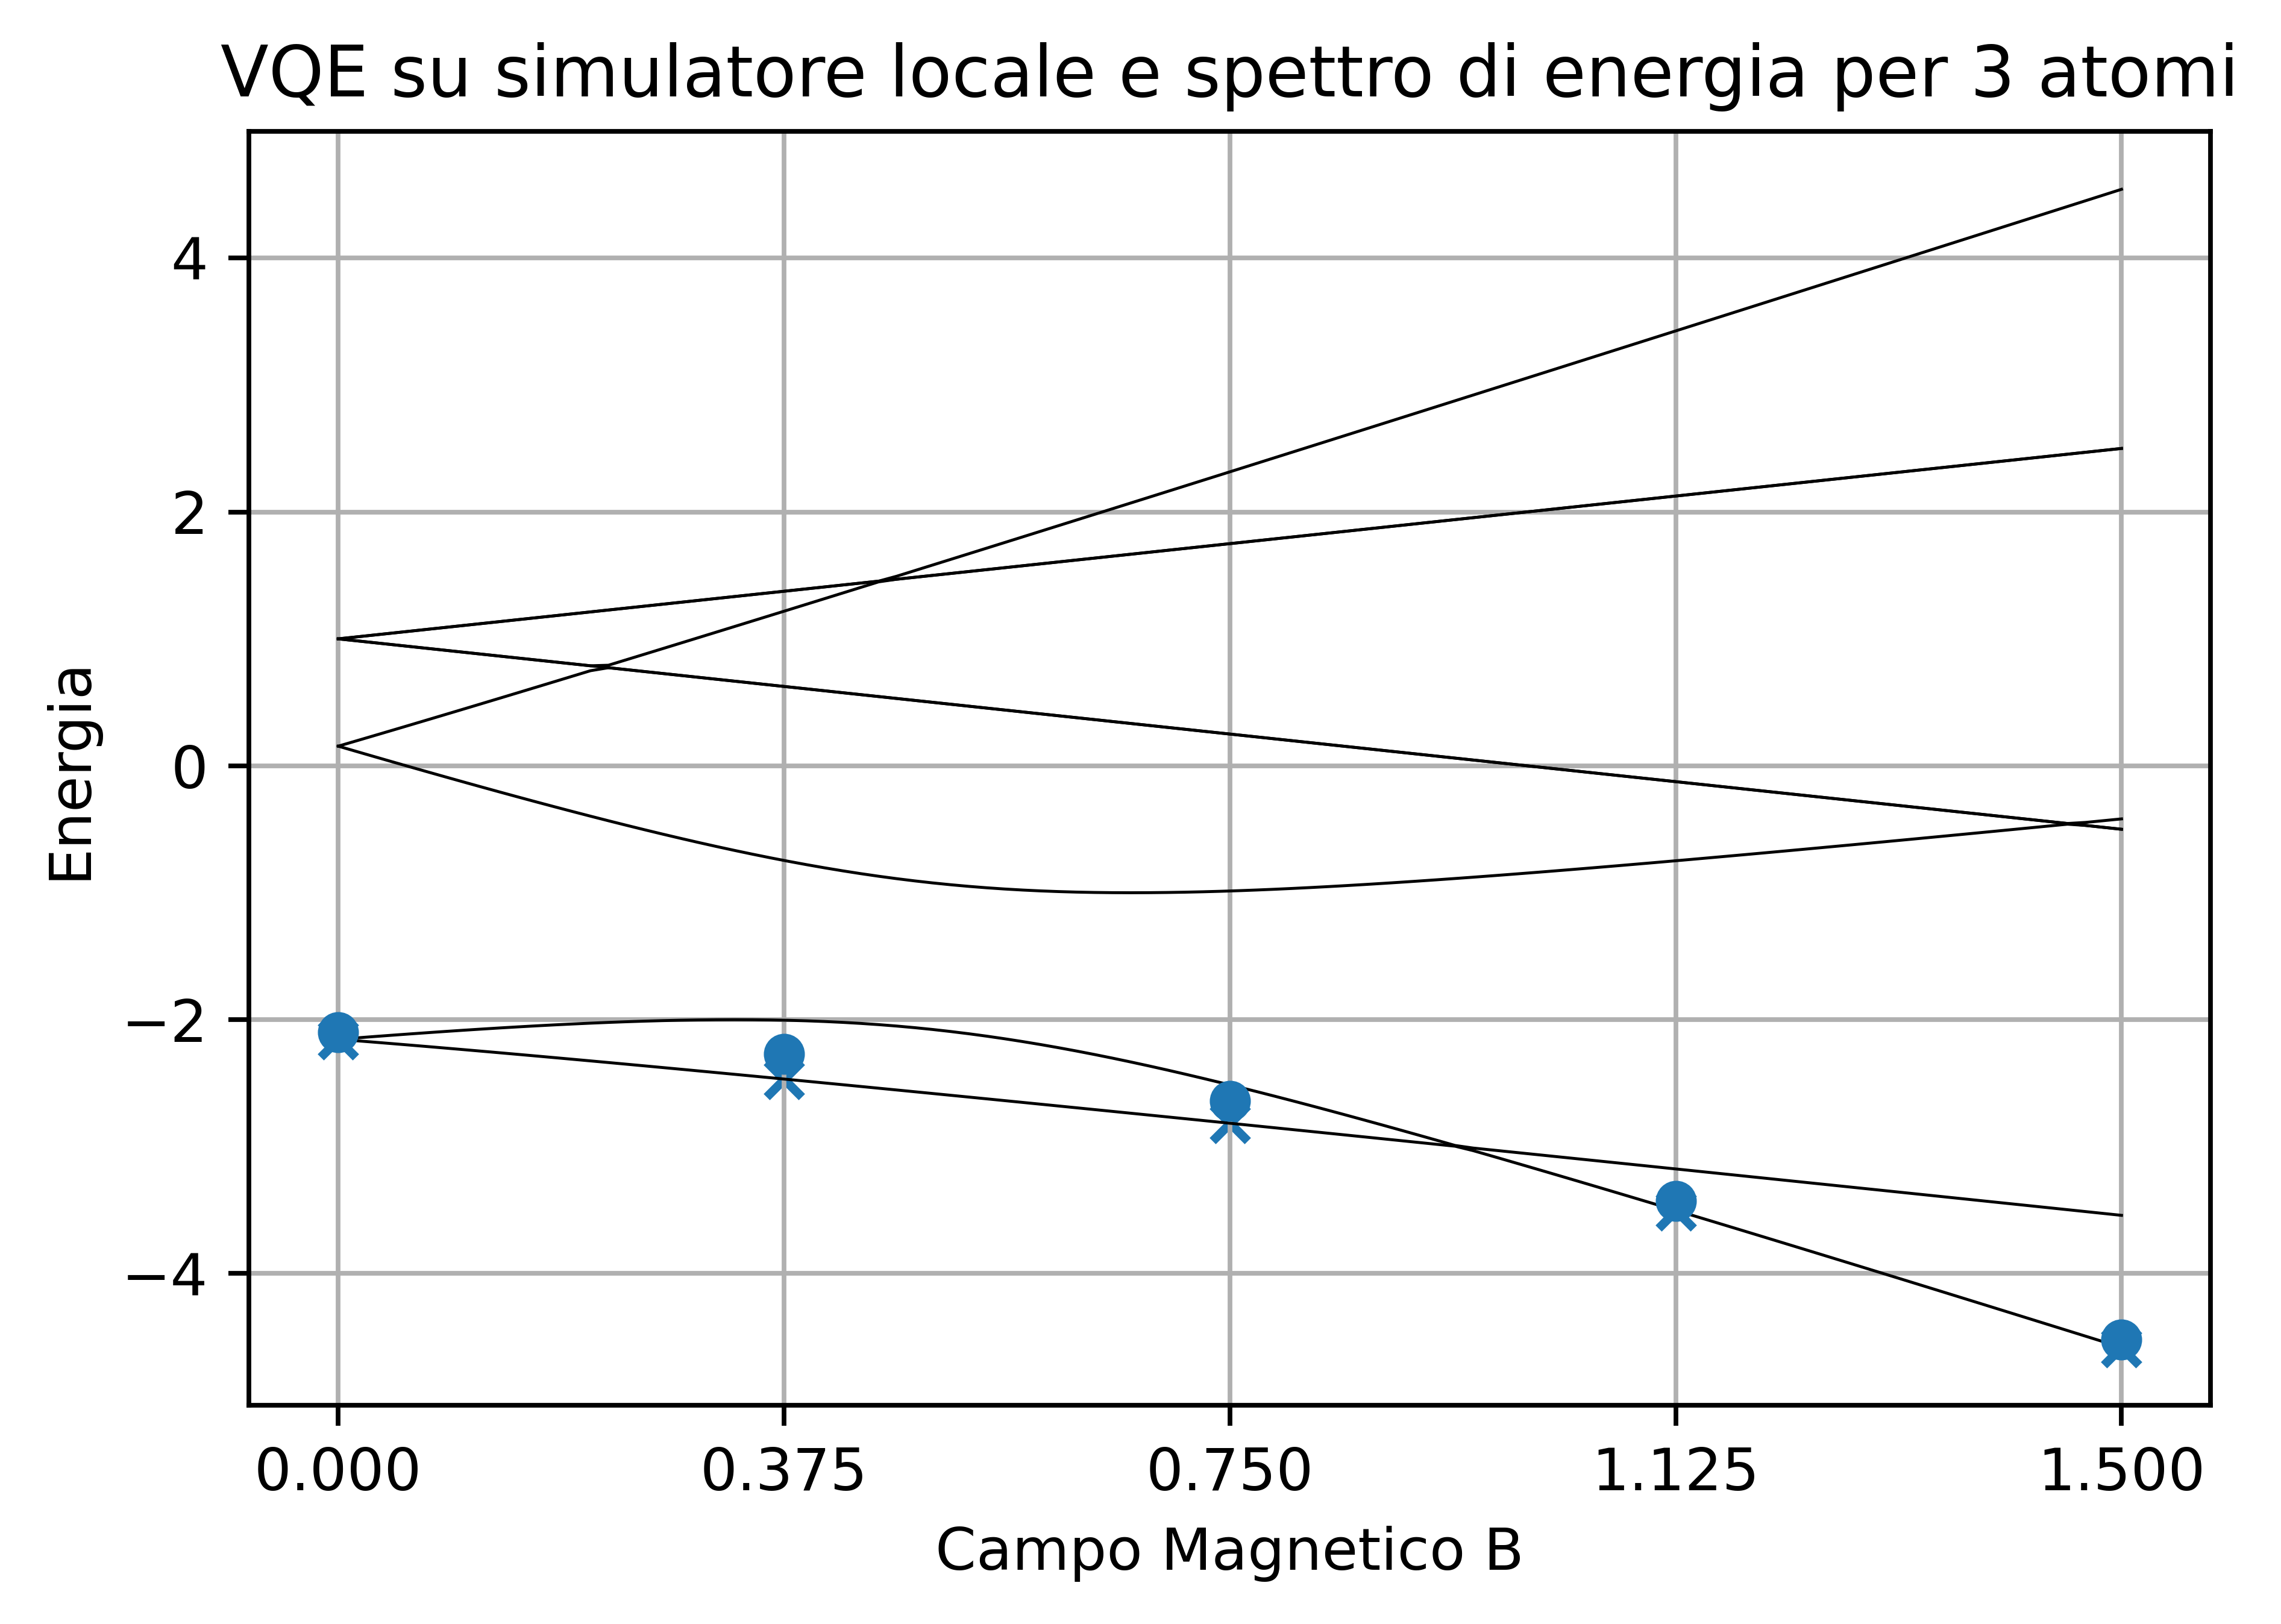

In [131]:
plot_qGS_spectrum(Bmin,Bmax,100,Neval,Natoms,J,gy,gz,qGSEigE,meanerr)

$B=0.0:\quad$

<IPython.core.display.Latex object>

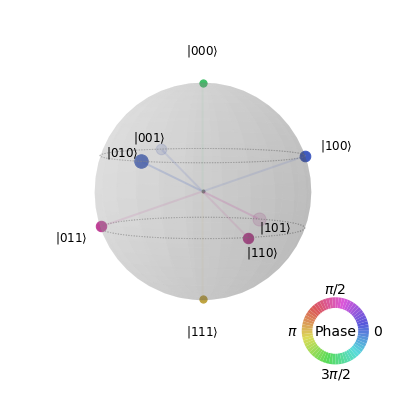

$B=0.375:\quad$

<IPython.core.display.Latex object>

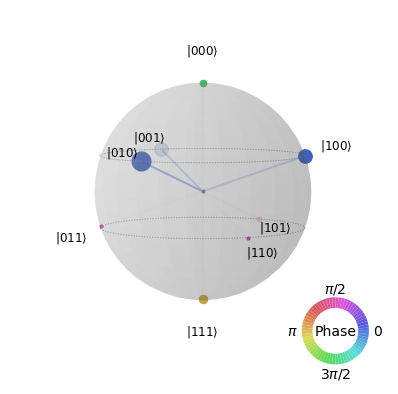

$B=0.75:\quad$

<IPython.core.display.Latex object>

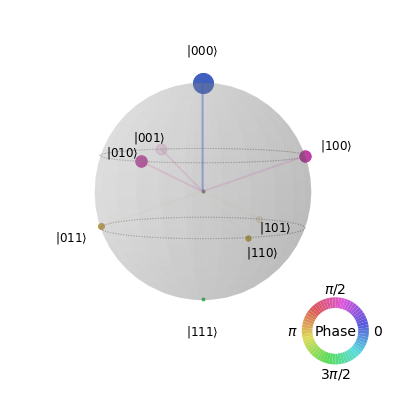

$B=1.125:\quad$

<IPython.core.display.Latex object>

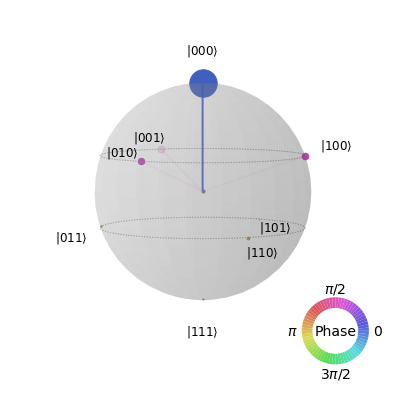

$B=1.5:\quad$

<IPython.core.display.Latex object>

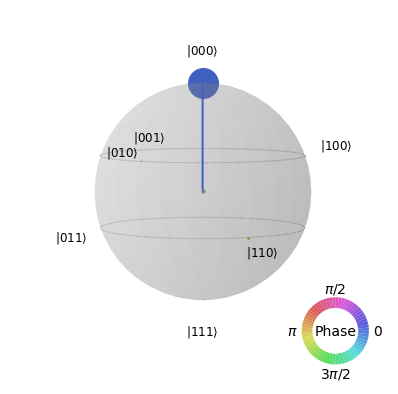

In [132]:
states = [[np.round(abs(j)**2,2)for j in i]for i in qGSstat]
states = [Statevector(entry) for entry in states]
for i in range(len(states)):
    display(Markdown(rf'$B={round(B[i],3)}:\quad$'),array_to_latex(states[i], prefix="\\left|\\psi_0\\right>="))#Statevector(qGSstat[i])
    display(plot_state_qsphere(qGSstat[i]))

### Hardware/Simulator VQE

#### Preparazione

In [134]:
shots = 8096

optimizer = COBYLA(maxiter=300, tol=0.001, rhobeg=1.0)

measurement_error_mitigation = True

qGSEigE1, meanerr1 = Custom_VQE_diag("noiseless",shots,optimizer)

'Finito.'

#### Risultati

In [188]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE1)):
    print(qGSEigE1[i],meanerr1[i])

Eigenvalues: Mean error:
-0.9035737812911725 0.004813886586859195
-1.1035902503293806 0.00780189037333875
-1.5010293148880105 0.007829423980803076
-2.249711791831357 0.0073923298208379545
-2.9822134387351777 0.009004962037354687


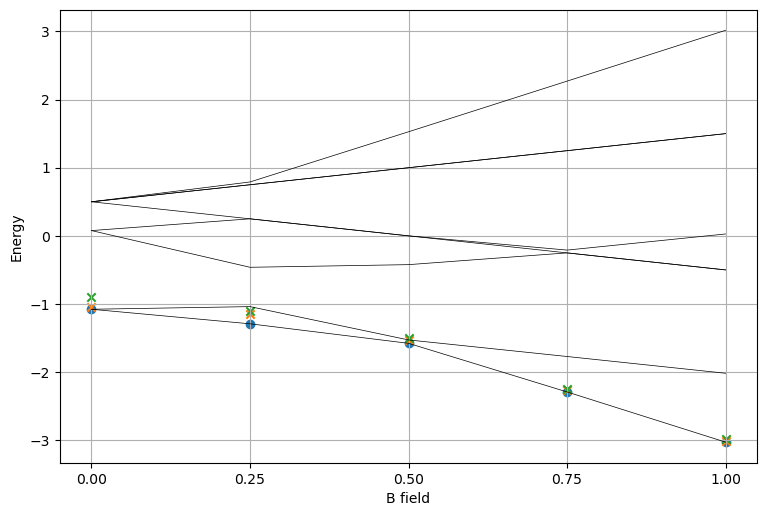

In [189]:
plot_tot([cGSEigE, EigE, qGSEigE, qGSEigE1])

### Caso 10 Atomi

In [135]:
Natoms = 10 #Cambiamo numero atomi
J = 1./Natoms # 1/Natoms
gy = 2
gz = 0
Bmin=0.
Bmax=2
Neval=5
B = np.linspace(Bmin,Bmax,Neval).tolist()

### Diagonalizzazione computazionale classica

In [544]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

In [545]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

In [546]:
##Funzione per considerare solo gli autostati ad energia più bassa

lowSEigE=[]

for i in EigE:
    tmp=[]
    for j in range(0,len(i)):
        if j<6:
            tmp.append(i[j])
    lowSEigE.append(tmp)

In [ ]:
spectrum_class_manyqubits(Bmin,Bmax,50,Natoms,J,gy,gz,-15,-5)

### Parte quantistica

In [548]:
qH = []
for k in range(len(B)):
    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k])
    #print((checkmat - cH[k])) dà sempre 0 se l'hamiltoniana è scritta bene
    qH.append(ham)

In [549]:
from qiskit.circuit.library import EfficientSU2

num_qubits = Natoms
# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='full', insert_barriers=True) 
#ansatz.decompose().draw('mpl', style='iqx')

In [550]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

maxiter=400 #Numero di iterazioni massime (con 50 nel range tra simmetrico 1.8 converge molto molto poco)

optimizer = SPSA(maxiter=maxiter)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [551]:

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),#QasmSimulatorPy(),
                callback=callback)

In [552]:
qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

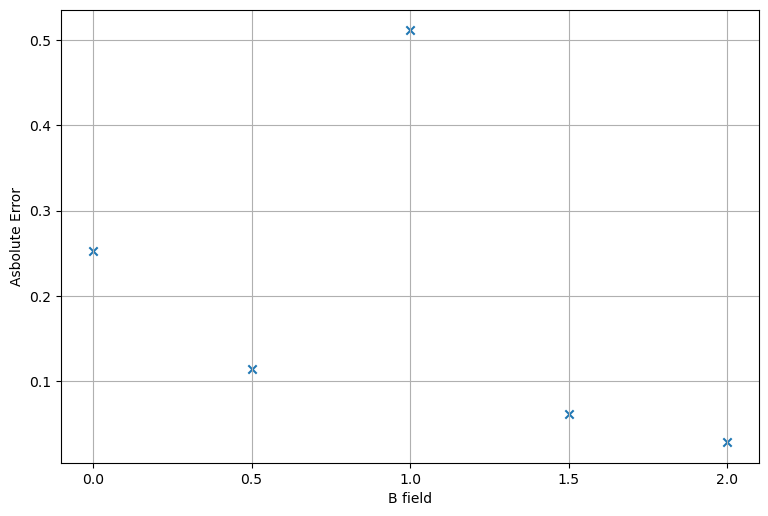

In [553]:
plot_abserr(B,cGSEigE,qGSEigE)

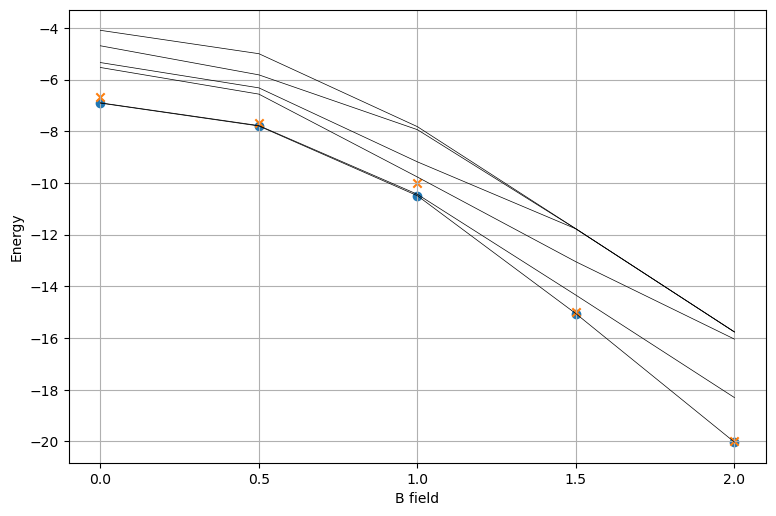

In [554]:
plot_tot([cGSEigE, lowSEigE, qGSEigE])

## Confronto tra ottimizzatori

A seconda del tipo di ottimizzatore ci aspettiamo performance diverse: Utilizzia gli ottimizzatori COBYLA, L_BFGS, SLSQP, SPSA. Hanno tutti caratteristiche diverse.

###### Questa parte di codice è importata dal main-checkpoint di Carlo, ho provato a integrare al meglio le funzioni definite prima ma potrebbero esserci ripetizioni

In [46]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
import numpy as np
import pylab


#from qiskit.providers.basicaer import QasmSimulatorPy                       # local simulator
from qiskit import Aer                                               #Uso statevector perché più veloce, però non ha errori, altrimenti usa qasm_simulator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA, GradientDescent      #Importo gli ottimizzatori


np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

# Lista degli ottimizzatori utilizzati
optimizers = [COBYLA(maxiter=200), SPSA(maxiter=200), GradientDescent(maxiter=42)]    #Scegliamo gli ottimizzatori


#Inizializzo array dei valori degli ottimizzatori
converge_nfev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]   #Lista di ndarray, ciascuno per ogni B
converge_parameters_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_energy_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_stddev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
    
qGSEigE = []    #Valori da mandare nella funzione per i grafici al variare di B
meanerr = []    

for j in range(len(qH)):
    
    for i, optimizer in enumerate(optimizers):
        
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(j+1,len(qH)))
        ipd_display('Optimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')
        #print('\rOptimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')

        #Reset dei valori di callback
        
        global intermediate_info
        intermediate_info = {
            'nfev': [],
            'parameters': [],
            'energy': [],
            'stddev': []
        }
        
        #nfev = []
        #par = []
        #energy = []
        #std = []
    #
        #def callback(eval_count, parameters, mean, stddev):
        #    nfev.append(eval_count)
        #    par.append(parameters)
        #    energy.append(mean)
        #    std.append(stddev)
        
        ##Qui non è molto comodo usare la funzione VQE custom dialog, lasciamo l'implementazione base
        local_vqe = VQE(ansatz=ansatz,
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')),
                    callback=callback)

        result = local_vqe.compute_minimum_eigenvalue(operator=qH[j])
        converge_nfev_qH[j][i] = intermediate_info['nfev']
        converge_parameters_qH[j][i] = intermediate_info['parameters']
        converge_energy_qH[j][i] = intermediate_info['energy']
        converge_stddev_qH[j][i] = intermediate_info['stddev']
        
    qGSEigE.append(converge_energy_qH[j][0][-1])                           #Scegliamo di quale ottimizzatore mostrare i
    meanerr.append(converge_stddev_qH[j][0][-1])                           #risultati(0 sta per COBYLA) 
    
ipd_clear(wait=True)
ipd_display("Completato.")

'Completato.'

Visualizziamo le convergenze degli ottimizzatori, a B fissato.

Fissiamo B=0, caso in cui ci aspettiamo massimo entanglement

In [50]:
B_fiss = 0      #Scegli quale passo di B fissare

Energia calcolata da ogni ottimizzatore ad ogni step dell'iterazione:

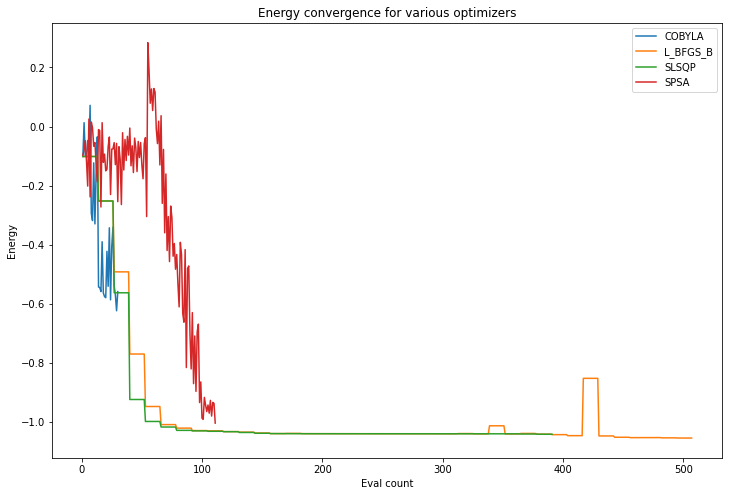

In [51]:
pylab.rcParams['figure.figsize'] = (15, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[B_fiss][i], converge_energy_qH[B_fiss][i], label=type(optimizer).__name__)
#print(converge_energy_qH[B_fiss][-1])
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Energia')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.legend(loc='upper right');

Commenti: perchè L_BFGS_B ha quel picco tra 0 e 50 valutazioni?

Ora vediamo quale ottimizzatore converge più velocemente rispetto al valore trovato classicamente (in percentuale):

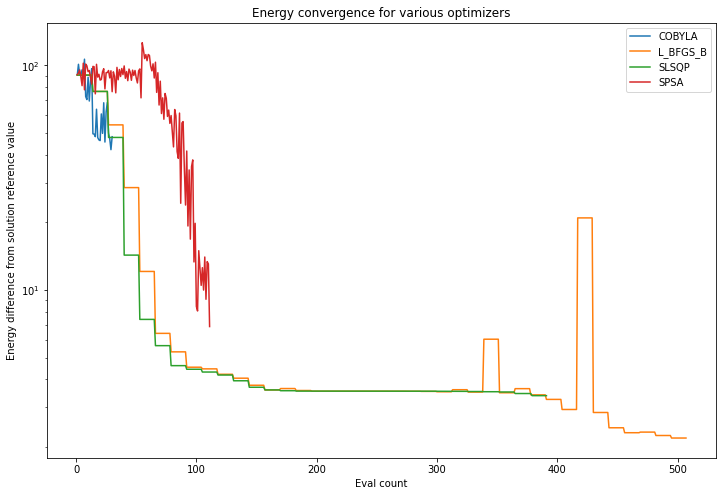

In [52]:
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams.update({'font.size': 15})  # fontsize of the figure title
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[B_fiss][i], abs(100*(cGSEigE[B_fiss] - converge_energy_qH[B_fiss][i])/cGSEigE[B_fiss]), label=type(optimizer).__name__)
    pylab.xlim([0, 594])
pylab.xlabel('Numero di iterazioni')
pylab.ylabel('Differenza (in percentuale) dalla soluzione di riferimento')
pylab.title('Convergenza di energia per diversi ottimizzatori')
pylab.yscale('log')
pylab.legend(loc='upper right');

Commenti: Nice

## Hamiltoniana n. 2: Interazioni anisotrope fra spin in campo magnetico $B$

$$\hat H = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma_y\hat \sigma_y^{(i)}\hat \sigma_y^{(j)} + \gamma_z\hat \sigma_z^{(i)}\hat \sigma_z^{(j)} \right) - B \sum_{i=1}^n\hat \sigma_z^{(i)}$$

### Valori dei parametri
Definiamo i valori dei parametri presenti nell'espressione dell'hamiltoniana:

I valori dei parametri dovrebbe passare da un rapporto $B/J$ grande tra termine di campo e spin (circa 4) ad un rapporto piccolo (circa 0.1). Circa citando il paper di grossi, quando il termine di campo è più forte dovremmo tendere ad effetto Zeeman, il GS tende allo stato con tutti gli spin allineati verso il basso. Quando il termine di spin domina invece ci aspettiamo che il GS sia entanglement di stati con spin su e giù.

#### Soluzione analitica

La hamiltoniana può essere divisa in due parti:
- $\hat H_1 = - J\sum_{\substack{i,j=1\\i<j}}^n\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma_y\hat \sigma_y^{(i)}\hat \sigma_y^{(j)}\right)$, che mescola le coppie $\left|00\right>$, $\left|11\right>$ e $\left|01\right>$, $\left|10\right>$ della base computazionale;
- $\hat H_2 = - J\sum_{\substack{i,j=1\\i<j}}^n\gamma_z\hat \sigma_z^{(i)}\hat \sigma_z^{(j)} - B \sum_{i=1}^n \hat\sigma_z^{(i)}$, di cui tutti gli stati della base computazionale sono autostati.

Allora, con un analisi analoga a quella del modello LMG con 2 qubit, studiando anche come si mescolano le due coppie individuate da $\hat H_1$, si trovano gli autovalori di $\hat H$:
- $E=-J\gamma_z\pm\sqrt{J^2(1-\gamma_y)^2+4B^2}$ per la coppia $\left|00\right>$ e $\left|00\right>$;
- $E=J(\gamma_z\pm(1+\gamma_y))$ per la coppia $\left|01\right>$ e $\left|10\right>$.

A questo punto, per i diversi valori di $J$ e $B$ basta vedere quale dei valori di $E$ è il minimo, ma non l'abbiamo fatto a mano perché dipende anche dal segno dei due parametri. Sicuramente, possiamo escludere che $E=-J\gamma_z+\sqrt{J^2(1-\gamma_y)^2+4B^2}$ sia l'energia dello stato fondamentale.

In [216]:
GS1 = [min(-J*gz-sqrt( J**2 * (1-gy)**2 + 4*i**2 ),J*(gz+1+gy),+J*(gz-1-gy)) for i in B]

### Diagonalizzazione computazionale "classica"

#### Costruzione di $\hat H$
Costruiamo la lista delle hamiltoniane sui diversi valori di $B$:

In [217]:
import numpy as np
from qiskit.opflow import X, Y, Z, I

##La versione "classica" di questa funzione utilizza Operatori del tipo Operators, che un eigensolver classico può utilizzare


def Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction

    #initialize 0-dimensional Operators
    field=Operator([0])
    spin=Operator([0])
    
    #cycle over all qubits
    for i in range(Natoms):
       
        #Adds the spin field interaction for each atom
        field=(field^I)-(B*((I^i)^Z))
        spin=spin^I
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spin -= ( J * ((I^j)^X^(I^(i-j-1))^X))
            spin -= (J*gy*((I^j)^Y^(I^(i-j-1))^Y))
            spin -= (J*gz*((I^j)^Z^(I^(i-j-1))^Z))
            
    return(spin+field)

In [218]:
cH = []
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

#### Algoritmo per risoluzione classica

In [219]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

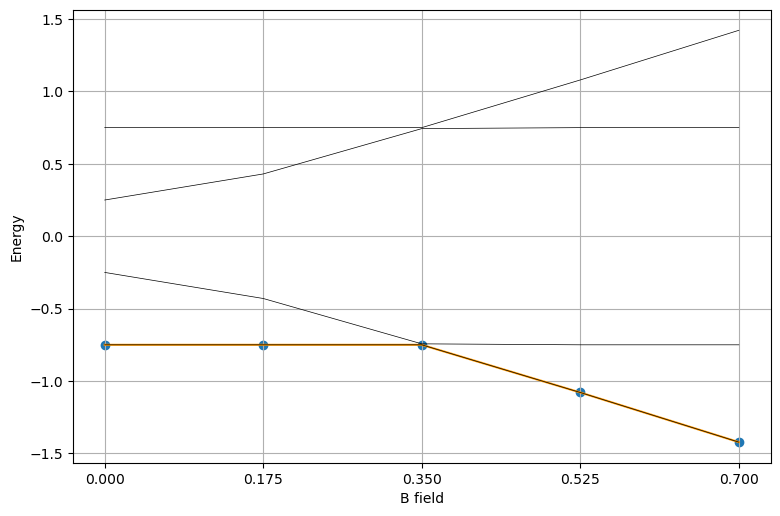

In [220]:
plot_class([cGSEigE, EigE, GS1])

### Diagonalizzazione quantistica con il VQE - Locale

#### Costruzione di $\hat H$
Costruiamo la lista delle hamiltoniane sui diversi valori di $B$:

In [221]:
##La versione quantistica utilizza operatori del tipo PauliOp che è l'unico tipo che l'algoritmo VQE accetta

def Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B):
    
    #Builds the N-atoms Hamiltonian for anisotropic Magnetic field-spin interaction
    
    #initialize 0-dimensional Operators
    init = primitive_ops.PauliOp(Pauli('I'*Natoms),0)
    field,spins = [init]*2
    
    #cycle over all qubits
    for i in range(Natoms):
    
        #Adds the spin field interaction for each atom
        field -= primitive_ops.PauliOp(Pauli('I'*i+'Z'+'I'*(Natoms-i-1)),B)
        
        #implementation for the i-th qubit
        #of spin-spin interactions with j-th qubit, with j<i
        for j in range(i):
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'X'+'I'*(i-j-1)+'X'+'I'*(Natoms-i-1)),J)
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'Y'+'I'*(i-j-1)+'Y'+'I'*(Natoms-i-1)),J*gy)
            spins -= primitive_ops.PauliOp(Pauli('I'*j+'Z'+'I'*(i-j-1)+'Z'+'I'*(Natoms-i-1)),J*gz)

    return (field+spins),Operator((field+spins).to_matrix())

In [222]:
qH = []
for k in range(len(B)):
    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k])
    #print((checkmat - cH[k])) #dà sempre 0 se l'hamiltoniana è scritta bene
    qH.append(ham)

#### Algoritmo

### Importante
La scelta di un buon circuito di ansatz è cruciale per rendere l'algoritmo efficiente. Restringere lo spazio di hilbert ad una dimensione più piccola possibile è molto molto importante. EfficientSU2 è un approccio euristico alla faccenda. Forse leggendo l'articolo di Grossi si capirà qualcosa di più. Finora è chiaro che: <br>
-Hamiltoniana commuta con la coniugazione complessa-> Autostati (e quindi GS) sono reali <br>
-Hamiltoniana commuta con (Spin Totale)(x + y +z)^2? <br>
-Hamiltoniana commuta con Spinz?

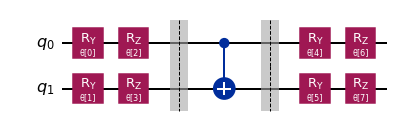

In [223]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

In [224]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [225]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator

import time

start_time = time.time()


local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),#QasmSimulatorPy(),
                callback=callback)

qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

print(time.time()-start_time)

'Finito.'

1.3753411769866943


#### Risultati

In [226]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-0.7452244067103015 0.0
-0.748799308099987 0.0
-0.7440323774150257 0.0
-1.0707975577248425 0.0
-1.4183664816555148 0.0


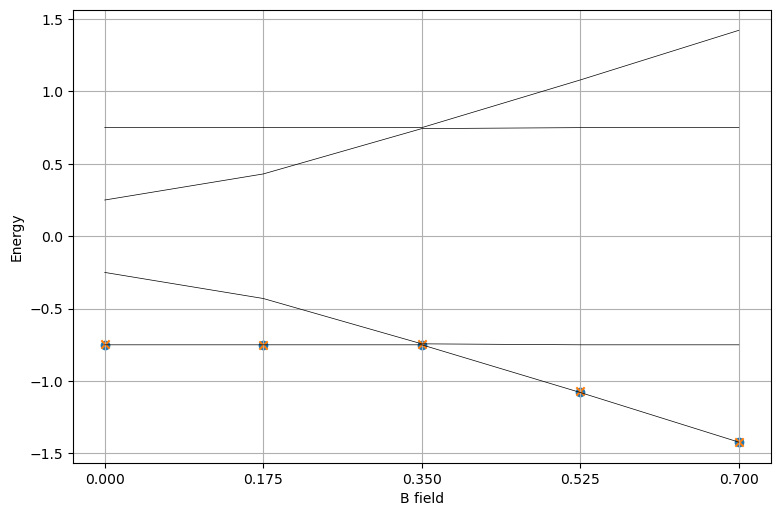

In [227]:
plot_tot([cGSEigE, EigE, qGSEigE])

In [228]:
for i in range(len(qGSstat)):
    display(Markdown(rf'$B={B[i]}:\quad$'),array_to_latex(Statevector(qGSstat[i]), prefix="\\left|\\psi_0\\right>"))

$B=0.0:\quad$

<IPython.core.display.Latex object>

$B=0.175:\quad$

<IPython.core.display.Latex object>

$B=0.35:\quad$

<IPython.core.display.Latex object>

$B=0.5249999999999999:\quad$

<IPython.core.display.Latex object>

$B=0.7:\quad$

<IPython.core.display.Latex object>

### Caso con N atomi

In [246]:
cH = []
Natoms = 3
J = 1/Natoms
gy = 0.5
gz = 0.
B = np.linspace(0,.7,5).tolist()#+np.linspace(.32,.38,4).tolist()+np.linspace(.4,.7,9).tolist()

#### Soluzione analitica

La hamiltoniana può essere divisa in due parti:
- $\hat H_1 = - \sum_{\substack{i,j=1\\i<j}}^n J\left( \hat \sigma_x^{(i)}\hat \sigma_x^{(j)} + \gamma_y\hat \sigma_y^{(i)}\hat \sigma_y^{(j)}\right)$, che mescola le quaterne $\left|000\right>$, $\left|110\right>$, $\left|101\right>$, $\left|011\right>$ e  $\left|111\right>$, $\left|001\right>$, $\left|010\right>$, $\left|100\right>$ della base computazionale;
- $\hat H_2 = - J \sum_{\substack{i,j\\i<j}}\gamma_z\hat\sigma_z^{(i)}\hat\sigma_z^{(j)} - B \sum_{i=1}^n \hat\sigma_z^{(i)}$, di cui tutti gli stati della base computazionale sono autostati.

Allora basta studiare come si mescolano le due quaterne, questa volta, individuate da $\hat H_1$ e si trovano due sistemi di equazioni di forma del tutto analoga a quella che permetteva di trovare i valori $E=-( B+J(1+\gamma))-2\sqrt{J^2(1+\gamma^2-\gamma)+B^2 - BJ(1+\gamma)}$ e $E= B + J(1+\gamma)$ per il modello LMG, con la differenza che dove prima si aveva $B$ ora si ha:
- $B\to J\gamma_z+B$ per la prima quaterna;
- $B\to J\gamma_z-B$ per la seconda.

Sostituendo $B$ e $\gamma$ delle formule precedenti rispettivamente con $J\gamma_z\pm B$ e $\gamma_y$ si trovano, quindi, gli autovalori di $\hat H$:
- $E=-( \pm B+J(1+\gamma_y+\gamma_z))-2\sqrt{J^2(1+\gamma_y^2+\gamma_z^2-\gamma_y-\gamma_z-\gamma_y\gamma_z)+B^2\mp BJ(1+\gamma_y-2\gamma_z)}$;
- $E= \pm B + J(1+\gamma_y+\gamma_z)$.

A questo punto, per i diversi valori di $J$ e $B$ basta vedere quale dei valori di $E$ è il minimo, ma non l'abbiamo fatto a mano perché dipende anche dal segno dei due parametri.

In [247]:
def compGS1(J,gy,gz,B):
    a = B + J * (1. + gy + gz)
    c = sqrt( J**2 * (1+gy**2+gz**2-gy-gz-gy*gz) + B**2 - B*J*(1+gy-2*gz) )
    energy = - a - 2*c
    return energy

def compGS2(J,gy,gz,B):
    a = - B + J * (1. + gy + gz)
    c = sqrt( J**2 * (1+gy**2+gz**2-gy-gz-gy*gz) + B**2 + B*J*(1+gy-2*gz) )
    energy = - a - 2*c
    return energy

In [248]:
GS1 = [min(compGS1(J,gy,gz,i),compGS2(J,gy,gz,i),i+J*(1+gy+gz),-i+J*(1+gy+gz)) for i in B]

In [249]:
##Ho scritto sta funzione per gli autovalori delle energie generiche del caso a 3 spin
##Non serve a molto, ma è qui per il futuro

def GSexact3(i):
    #Trova la soluzione esatta (analitica) per il caso di una hamiltoniana lmg con 3 spin
    #La soluzione è presa dall'appendice dell'articolo http://dx.doi.org/10.1103/PhysRevA.90.022111
    u=gy-1
    v=gy+1
    DELTAp=2*sqrt(1+ 9*i**2 + 3*i*v +gy*u)
    DELTAn=2*sqrt(1+ 9*i**2 - 3*i*v +gy*u)
    deltap= -6*i +v
    deltan= -6*i -v
    mu1=(v-3*i)/3
    #mu2=mu1
    mu3=(v+3*i)/3
    #mu4=mu3
    mu5=(-3*i -v - DELTAn)/3
    mu6=(-3*i -v + DELTAn)/3
    mu7=(3*i -v - DELTAp)/3
    mu8=(3*i -v + DELTAp)/3
    return [mu1,mu3,mu5,mu6,mu7,mu8]


#### Diagonalizzazione computazionale "classica"

In [250]:
for k in B:
    cH.append(Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,k))

In [251]:
cGSEigE, EigE = class_par_H_diagonalizer(cH)

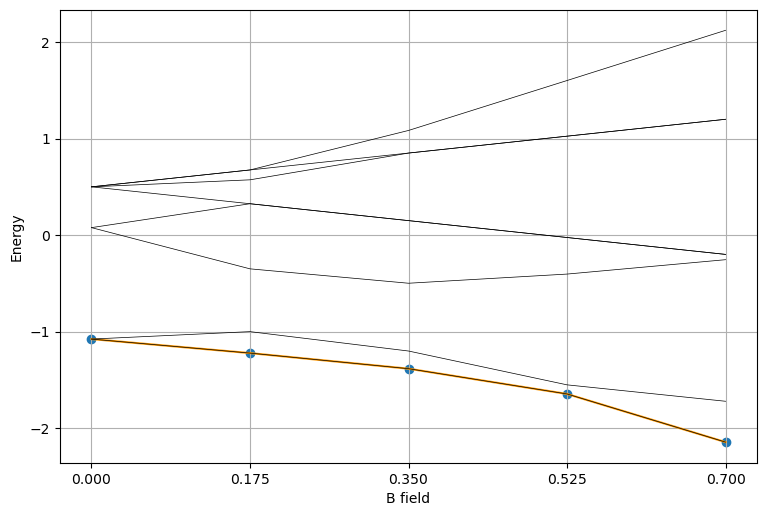

In [252]:
plot_class([cGSEigE, EigE, GS1])

#### Diagonalizzazione quantistica con il VQE

In [253]:
qH = []
for k in range(len(B)):
    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B[k])
    #print((checkmat - cH[k])) dà sempre 0 se l'hamiltoniana è scritta bene
    qH.append(ham)

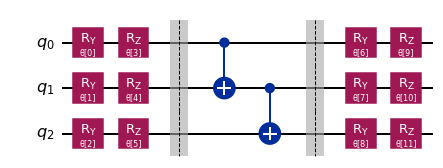

In [254]:
from qiskit.circuit.library import EfficientSU2

num_qubits = Natoms
# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

##### Scelta di ottimizzatore vqe

In [255]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

maxiter=400 #Numero di iterazioni massime (con 50 nel range tra simmetrico 1.8 converge molto molto poco)

optimizer = SPSA(maxiter=maxiter)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

#### Local VQE

In [256]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),#QasmSimulatorPy(),
                callback=callback)

In [257]:
qGSEigE, qGSstat, meanerr = VQE_par_H_diagonalizer(local_vqe,qH)

'Finito.'

In [258]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE)):
    print(qGSEigE[i],meanerr[i])

Eigenvalues: Mean error:
-1.0177678259583502 0.0
-1.0858803259187444 0.0
-1.275668348790177 0.0
-1.5876877395490177 0.0
-2.109790713013192 0.0


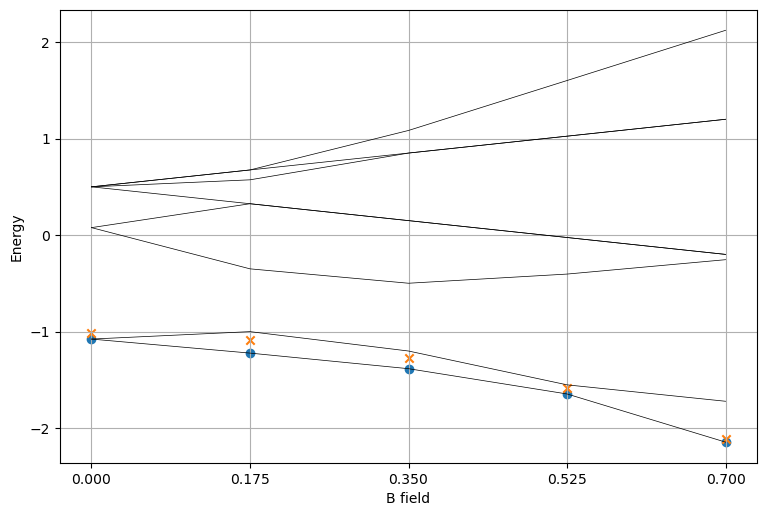

In [261]:
plot_tot([cGSEigE, EigE, qGSEigE])

In [262]:
for i in range(len(qGSstat)):
    display(Markdown(rf'$B={B[i]}:\quad$'),array_to_latex(Statevector(qGSstat[i]), prefix="\\left|\\psi_0\\right>"))

$B=0.0:\quad$

<IPython.core.display.Latex object>

$B=0.175:\quad$

<IPython.core.display.Latex object>

$B=0.35:\quad$

<IPython.core.display.Latex object>

$B=0.5249999999999999:\quad$

<IPython.core.display.Latex object>

$B=0.7:\quad$

<IPython.core.display.Latex object>

#### Hardware/Simulator VQE

##### Esecuzione

In [263]:
shots = 8096

# in this first release, the optimizer must be specified as dictionary
#optimizer = {'name': 'SPSA', 'maxiter': 50}
optimizer = COBYLA(maxiter=50, tol=0.001, rhobeg=1.0)

measurement_error_mitigation = True

qGSEigE1, meanerr1 = Custom_VQE_diag("noiseless",shots,optimizer)

'Finito.'

##### Risultati

In [264]:
print('Eigenvalues:','Mean error:')
for i in range(len(qGSEigE1)):
    print(qGSEigE1[i],meanerr1[i])

Eigenvalues: Mean error:
-1.0181982872200261 0.00418799894234852
-1.0478981389986826 0.006232505495961056
-1.2722908432147562 0.009093725507815977
-1.5921772068511195 0.00943678621752143
-2.1005105401844535 0.008527143444296968


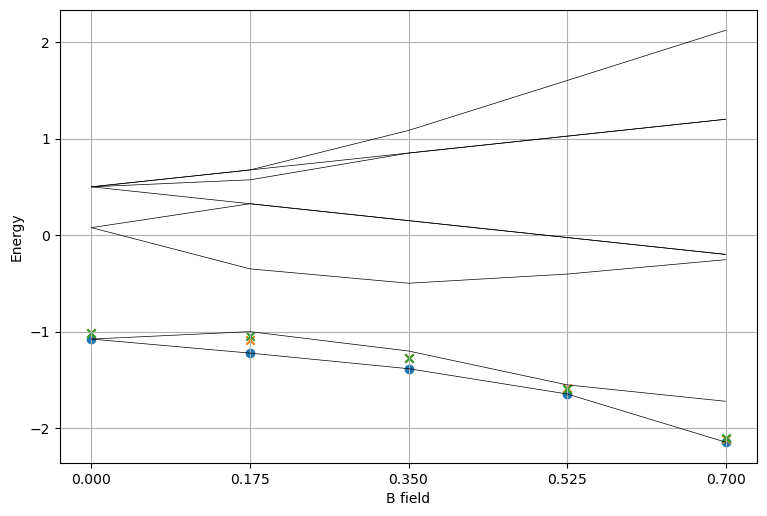

In [265]:
plot_tot([cGSEigE, EigE, qGSEigE, qGSEigE1])

## Confronto tra ottimizzatori

In [266]:
from IPython.display import display as ipd_display, clear_output as ipd_clear
import numpy as np
import pylab


#from qiskit.providers.basicaer import QasmSimulatorPy                       # local simulator
from qiskit import Aer                                               #Uso statevector perché più veloce, però non ha errori, altrimenti usa qasm_simulator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA      #Importo gli ottimizzatori


np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

# Lista degli ottimizzatori utilizzati
optimizers = [COBYLA(maxiter=30), L_BFGS_B(maxiter=30), SLSQP(maxiter=30), SPSA(maxiter=30)]    #Scegliamo gli ottimizzatori


#Inizializzo array dei valori degli ottimizzatori
converge_nfev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]   #Lista di ndarray, ciascuno per ogni B
converge_parameters_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_energy_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
converge_stddev_qH = [np.empty([len(optimizers)], dtype=object) for z in range(len(qH))]
    
qGSEigE = []    #Valori da mandare nella funzione per i grafici al variare di B
meanerr = []    

for j in range(len(qH)):
    
    for i, optimizer in enumerate(optimizers):
        
        ipd_clear(wait=True)
        ipd_display("%da iterazione di %d"%(j+1,len(qH)))
        ipd_display('Optimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')
        #print('\rOptimizer: {}        ({} di {})'.format(type(optimizer).__name__,i+1,len(optimizers)))#, end='')

        #Reset dei valori di callback
        
        global intermediate_info
        intermediate_info = {
            'nfev': [],
            'parameters': [],
            'energy': [],
            'stddev': []
        }
        
        #nfev = []
        #par = []
        #energy = []
        #std = []
    #
        #def callback(eval_count, parameters, mean, stddev):
        #    nfev.append(eval_count)
        #    par.append(parameters)
        #    energy.append(mean)
        #    std.append(stddev)
        
        ##Qui non è molto comodo usare la funzione VQE custom dialog, lasciamo l'implementazione base
        local_vqe = VQE(ansatz=ansatz,
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')),
                    callback=callback)

        result = local_vqe.compute_minimum_eigenvalue(operator=qH[j])
        converge_nfev_qH[j][i] = intermediate_info['nfev']
        converge_parameters_qH[j][i] = intermediate_info['parameters']
        converge_energy_qH[j][i] = intermediate_info['energy']
        converge_stddev_qH[j][i] = intermediate_info['stddev']
        
    qGSEigE.append(converge_energy_qH[j][3][-1])                           #Scegliamo di quale ottimizzatore mostrare i
    meanerr.append(converge_stddev_qH[j][3][-1])                           #risultati(0 sta per COBYLA) 
    
ipd_clear(wait=True)
ipd_display("Completato.")

'Completato.'

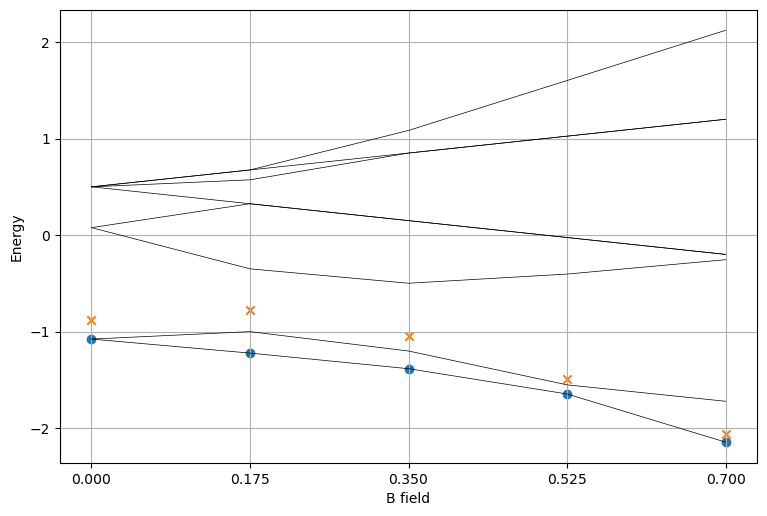

In [267]:
plot_tot([cGSEigE, EigE, qGSEigE])

Fissiamo B=0, caso in cui ci aspettiamo massimo entanglement

In [268]:
B_fiss = 0      #Scegli quale passo di B fissare

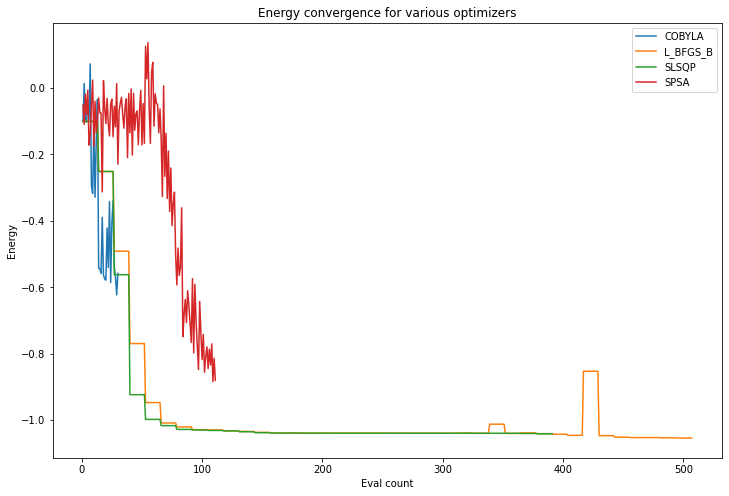

In [269]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[B_fiss][i], converge_energy_qH[B_fiss][i], label=type(optimizer).__name__)
#print(converge_energy_qH[B_fiss][-1])
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

Commenti: perchè L_BFGS_B ha quel picco tra 0 e 50 valutazioni?

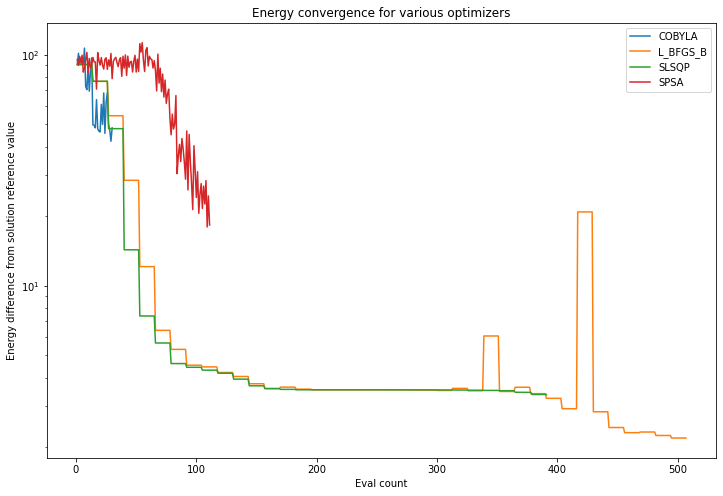

In [270]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_nfev_qH[B_fiss][i], abs(100*(cGSEigE[B_fiss] - converge_energy_qH[B_fiss][i])/cGSEigE[B_fiss]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');

### Circuito hamiltoniana
Utilizziamo un hamiltoniana di diversa profondità nel caso di campo intermedio.

In [107]:
## Scriviamo hamiltoniana

In [108]:
#from qiskit.circuit.library import GMS, MSGate
#from qiskit.circuit import Parameter
#a=Parameter('a')
#b=Parameter('b')
#c=Parameter('c')
#theta=[[0, np.pi/a, np.pi/b],
#                                   [0, 0, np.pi/c],
#                                   [0, 0, 0]]
#GMSgate=GMS(num_qubits=3, theta=[[0, np.pi/a, np.pi/b],
#                                   [0, 0, np.pi/c],
#                                   [0, 0, 0]]).to_gate()
#GMSgate_def=QuantumCircuit(3)
#GMSgate_def.append(GMSgate,[0,1,2])
#
#testcirc=QuantumCircuit(4)
#testcirc.append(GMSgate,[0,1,2])
#
#testcirc.draw()
#
#Ion_circuit=transpile(circuit,basis_gates=['rxxx','rz','ry','rx'])

In [110]:
from qiskit.circuit.gate import Gate
from qiskit.quantum_info import Operator
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.circuit.quantumcircuit import QuantumCircuit
import pylab


#Provider del simulatore del computer quantistico Ion-trap: per tutorial
#https://github.com/Qiskit-Partners/qiskit-aqt-provider

from qiskit_aqt_provider import AQTProvider
aqt = AQTProvider('MY_TOKEN') #Sembra non avere davvero bisogno di un token vero
backend = aqt.backends.aqt_qasm_simulator


#Array dei circuiti


SC=[]
IT=[]
SC_depth=[]
IT_depth=[]

#Parametri dell'operatore evoluzione temporale

timestep=0.5
gy = 0.5
gz = 0.
B = 0.3

#Massimo numero di quibits

MaxQubits=7

for i in range(2,MaxQubits+1):
    #Aggiorniamo numero qubit e il parametro J
    Natoms = i
    J = 1/Natoms 
    
    #Costruzione gate e circuito

    ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B) #Ricavo PauliSumOp    
    operator=Operator(ham.to_matrix()) #Da PauliSumOp a Operator
    gate = HamiltonianGate(operator,timestep) #Da operatore a gate
    circuit = QuantumCircuit(Natoms) 
    circuit.append(gate, range(0,Natoms)) #Da gate a circuito
    #circuit.draw('mpl', style='iqx') #Step opzionale per disegnare il circuito
    
    SC_qc=transpile(circuit,basis_gates=['cx','id','rz','sx','x']) #Transpiling sui gate del computer a super conducting qubit
    IT_qc = transpile(circuit, backend)
    
    SC.append(SC_qc)
    IT.append(IT_qc)
    
    SC_depth.append(SC_qc.depth())
    IT_depth.append(IT_qc.depth())
    
    print("iterazione ",i-1,"di ",MaxQubits-1,"completata")
    

iterazione  1 di  4 completata
iterazione  2 di  4 completata
iterazione  3 di  4 completata
iterazione  4 di  4 completata


Ricavate le profondita dei circuiti, disegnamo il confronto e poi disegnamo i due circuiti per un certo numero di gates

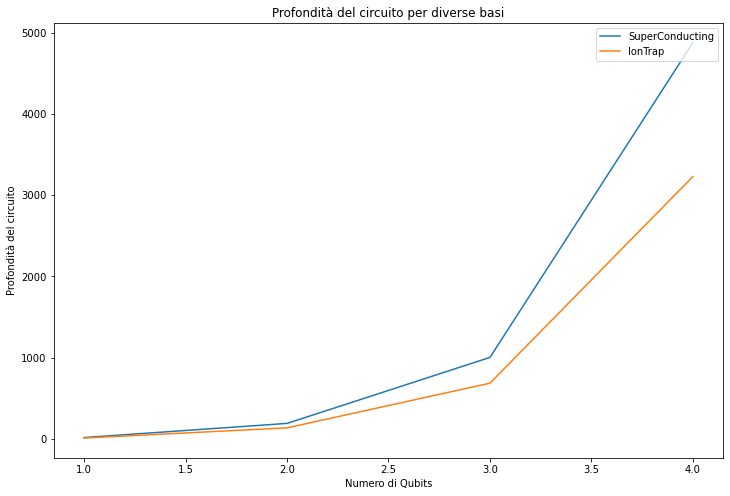

In [111]:
##Funzione di Plot delle profondità, confrontate a numero pari di qubit

Circ_depth=[SC_depth,IT_depth]
Circ_label=["SuperConducting","IonTrap"]
pylab.rcParams['figure.figsize'] = (12, 8)
for i in range(len(Circ_depth)):
    pylab.plot(range(1,len(Circ_depth[i])+1), Circ_depth[i], label=Circ_label[i])
pylab.xlabel('Numero di Qubits')
pylab.ylabel('Profondità del circuito')
pylab.title('Profondità del circuito per diverse basi')
#pylab.yscale('log')
pylab.legend(loc='upper right');

Commenti: Nice

In [556]:
##Disegno i circuiti per un certo numero di Qubit:
myN=3
#SC[myN-2].draw('mpl', style='iqx')


In [555]:
#IT[myN-2].draw('mpl', style='iqx')

## Ansatz time

Confronto tra diversi ansatz e tante cose

In [58]:
from qiskit.circuit.gate import Gate
from qiskit.quantum_info import Operator
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.circuit.quantumcircuit import QuantumCircuit
import pylab


In [59]:
from qiskit.circuit import Parameter

def PMA_ansatz(Natoms):

    #definiamo il gate W di 2 qubit, hamiltonian inspired

    theta = Parameter('θ')
    Wgatecirc=QuantumCircuit(2) 
    Wgatecirc.cx(0, 1)
    Wgatecirc.rz(theta,1)
    Wgatecirc.cx(0, 1)

    Wgate=Wgatecirc.to_gate()

    #Costruiamo il PMA ansatz come V gate
    
    PMA_ansatz=QuantumCircuit(Natoms)
    for i in range(Natoms):
        for j in range(i+1):
            if j != i:        
                PMA_ansatz.append(Wgate,[i,j])
    return(PMA_ansatz)


In [60]:
Natoms = 4
J = 1/Natoms
gy = 0.5
gz = 0
Neval=5
B = 2

Consideriamo un hamiltoniana che ci aspettiamo

In [61]:
ham, checkmat = Spin_Magnet_Hamilton_quant(Natoms,J,gy,gz,B)

In [88]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = QuantumCircuit(Natoms)
#ansatz.x(0)
ansatz.append((PMA_ansatz(Natoms).to_gate()),range(Natoms))
initial_point = np.zeros(ansatz.num_parameters)

In [79]:
ansatz = EfficientSU2(Natoms, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)

In [89]:
import numpy as np
from qiskit.algorithms.optimizers import COBYLA

maxiter=100 #Numero di iterazioni massime (con 50 nel range tra simmetrico 1.8 converge molto molto poco)

optimizer = COBYLA(maxiter=50, tol=0.001, rhobeg=1.0)


In [90]:
from qiskit.providers.basicaer import StatevectorSimulatorPy, QasmSimulatorPy  # local simulator

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=StatevectorSimulatorPy(),#QasmSimulatorPy(),
                callback=callback)

local_result = local_vqe.compute_minimum_eigenvalue(operator=ham)
print(local_result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 14,
    'eigenstate': array([-0.98285012-0.18440619j,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ]),
    'eigenvalue': (-8.000000000000007+0j),
    'optimal_parameters': {Parameter(θ): 0.985375},
    'optimal_point': array([0.985375]),
    'optimal_value': -8.000000000000007,
    'optimizer_evals': None,
    'optimizer_time': 0.03905606269836426}


In [82]:
14
0.03905606269836426
50
0.1471538543701172

0.1471538543701172

In [83]:
cH=Spin_Magnet_Hamilton_class(Natoms,J,gy,gz,B)

In [84]:
E_l, P_l = linalg.eig(cH.data)
cGS=E_l.min()

In [85]:
cGS

(-8.014404129896594+0j)

In [86]:
E_l

array([-8.01440413e+00+0.j, -1.49546013e+00+0.j,  8.00986426e+00+0.j,
       -5.14253967e+00+0.j,  2.89253967e+00+0.j, -3.62695265e+00+0.j,
       -3.62695265e+00+0.j,  4.37695265e+00+0.j,  4.37695265e+00+0.j,
       -3.62695265e+00+0.j,  4.37695265e+00+0.j,  7.50000000e-01+0.j,
        7.50000000e-01+0.j, -3.02063762e-16+0.j, -7.77885850e-17+0.j,
        2.78859932e-16+0.j])